# 66% Balanced Consensus: BERT-Based Financial Sentiment Classifier

This document provides an explanation of the python script used to train a classifier on top of a BERT model via fine-tuning. The task is financial sentiment analysis, where sentences are classified into three sentiments: negative, neutral, and positive.

## Dataset

The dataset is [hosted on Hugging Face,](https://huggingface.co/datasets/financial_phrasebank) where you can find further information on its curation, motivation, and annotation.

### Overview

The dataset consists of 4846 lines, each containing a financial text sentence and its corresponding sentiment, separated by an '@' symbol. The sentiment can belong to one of three categories: Negative, Neutral, or Positive, and is distributed as:

- Neutral: 2879 entries (59%)
- Positive: 1363 entries (28%)
- Negative: 604 entries (12.4%)

### Data Fields

- **sentence**: A tokenized line from the dataset.
- **label**: A label representing the sentence class as a string: 'positive', 'negative', or 'neutral'.

### Data Splits

Although the dataset does not come with predefined training/validation/test splits, the sentences are categorized into different configurations based on the degree of agreement among the annotators:

- **sentences_50agree**: Number of instances with >= 50% annotator agreement - 4846 sentences
- **sentences_66agree**: Number of instances with >= 66% annotator agreement - 4217 sentences
- **sentences_75agree**: Number of instances with >= 75% annotator agreement - 3453 sentences
- **sentences_allagree**: Number of instances with 100% annotator agreement - 2264 sentences

For this project, we use the `sentences_50agree` configuration comprising of 4846 instances and manually split it into training, validation, and testing sets in a 70-15-15 proportion.

All sentences in the dataset are limited to fewer than 512 tokens, in accordance with the BERT model's input constraints.

## Imports and System Setup

The first part of the code includes importing necessary modules and setting up the TensorFlow environment to recognize accessible GPU devices.


## Metrics

The model's performance after training is evaluated based on accuracy and F1 score. Accuracy measures the proportion of correct predictions, while the F1 score provides a harmonic mean between precision and recall, hammered down for individual classes.

F1 score is calculated after each epoch by a custom F1_Evaluation class that uses the Scikit-learn function `f1_score()` for calculation.

We took the extra step of tracking the F1 score for the validation set for a few reasons due to using a financial dataset:

- **Handling Imbalance**: Financial datasets often exhibit class imbalance. For instance, genuine transactions significantly outnumber fraudulent ones. Accuracy can be misleading in such cases, making F1 a more balanced metric as it considers both precision and recall.

- **Balancing Costs**: Both false negatives (e.g., overlooking a negative sentiment) and false positives (e.g., misclassifying a neutral statement as negative) have implications. The F1 score ensures a balance between reducing these two error types.

- **Threshold Tuning**: Financial decisions can involve adjustable thresholds. The F1 score can guide optimization, ensuring neither precision nor recall is neglected.

## Wandb

[Wandb (Weights & Biases)](https://wandb.ai/site) is used for experiment tracking.

## Preprocessing

The data is read from the .txt file. The file encoding is first detected using the `chardet` library, and then the data is loaded into a pandas DataFrame using the detected encoding. The DataFrame contains two columns: sentence and label.

Then the data is split into train, validation, and test sets, stratifying on the label to respect the original distribution of classes in the dataset.

The `BertTokenizer` is used to encode the sentences into format suitable for the BERT model. `truncation=True` and `padding=True` ensures that all sequences are of the same length.

The tokenized sentence encodings and the corresponding labels are wrapped into TensorFlow's `Dataset` objects.

## Model Creation

The existing BERT model ('bert-base-uncased') from HuggingFace's transformer models is loaded for sequence classification with 3 labels (negative, neutral, positive).

## Model Compilation and Training

The model is compiled with Adam optimizer, `SparseCategoricalCrossentropy` loss function, and accuracy as a metric. We use `SparseCategoricalCrossentropy` as this is a  multi-class classification with integer labels (not one-hot encoded). It's memory-efficient, especially for many classes, and pairs with a softmax activation in the model's output.

A Wandb run is initialized, and the data is fit on the model using a batch size of 8 for 10 epochs. The validation data and the custom F1 score calculation callback are also passed in the fit method.

## Evaluation

The model is evaluated on the test set. Classification report and F1 score are printed to show detailed information about performance on all three categories. The F1 score is also logged to the Wandb run.

In [1]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 26.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.8 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=296466b1901bd78949380df73a3e432eb2f36e284df3a364a48846e4c5251e6b
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 97.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.8 MB/s eta 0:00:00


In [3]:
# Easy place to track what we're training
WHICH_DATASET = 'Sentences_66Agree.txt'
WHICH_RUN_NAME = 'bert-balanced-66Agree'
seed_val = 42

# Import necessary libraries
import os

# Used to suppress output for F1 validation calculation
import io
import contextlib

# For encoding detection
import chardet

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split

# Hugging Face Transformers for BERT
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import BertConfig, BertTokenizer, TFBertForSequenceClassification


# Deep learning frameworks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import MeanSquaredError, SparseCategoricalCrossentropy
import tensorflow.keras.backend as K


# Ensure we have a GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Verify current GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# Weights and Biases for tracking experiments
import wandb
from wandb.keras import WandbCallback
from sklearn.metrics import f1_score

from google.colab import drive
drive.mount('/content/drive')

Num GPUs Available:  1
Found GPU at: /device:GPU:0
Mounted at /content/drive


# Prepare Data

## Overview

The varying levels of annotator agreements creates an unusual challenge. The aim is to create a train, test, and validation split that does not bias the model towards obvious sentiments. This guide will describe each step in the data splitting process.

## Step 1: Load the Data

Firstly we load the dataset files (which are text files in this case). Considering the possibility that these text files might have different encodings (they initially crashed the program as they use `ISO-8859-1`), we use Python's `chardet` library to detect the encoding before reading the file. This ensures that the loading of files doesn't fail due to encoding issues. The data is then shuffled randomly. The shuffling was an easy thing to miss, as previously we had used `train_test_split` from `scikit-learn` to split the data, and it had automatically shuffled the data. The data actually comes nearly sorted by sentiment, so without shuffling the model can't be fine-tuned at all.

The files are read in the following way:
- Every sentence in the dataset is separated by an '@' delimiter.
- There are no headers in the files so they are assigned later as ['sentence', 'label'].
- We use pandas' `read_csv` function to read these files.

## Step 2: Create a Subset from 'sentences_50agree'

The `sentences_50agree` dataset is the largest and most diverse dataset. To avoid overfitting and create a diverse validation set, we create a subset from this dataframe that will later be used for validation/testing. This subset is the same size as the train set.

## Step 3: Split the Subset into Validation and Test Sets

The subset created from `sentences_50agree` is split into validation and test sets. Here, a stratified sampling is performed to ensure that the split datasets have instances of each class ('positive', 'negative', and 'neutral') in proportions close to their original distribution in the parent dataset. The dataset is split in such way that 31% data is used for validation/testing. We choose 31% as this seems to result in the closest to a 70/15/15 train/validate/test split once the datasets have been assembled.

## Step 4: Update the Training Set

After obtaining the validation and test sets, we remove sentences present in these sets from the training set. This is done to avoid data leakage and ensure that the model doesn't see any sentence in the training phase that it would later encounter in the validation/testing phase.

## Step 5: Further Divide the Validation and Test Sets

The validation/test set subset is then divided equally into two parts: one part forms the validation set and the other part forms the test set.

## Step 6: Output the Sizes and Percentages

Finally, after creating all the datasets, we output the sizes of the train, validation, and test datasets along with their respective percentages to make sure that the classes are as balanced as they can be given the data.

This completes our data splitting process ensuring that we have a good mix of data in each dataset and our model does not get biased towards the easy-to-identify financial sentiments.

In [4]:
# Load a dataset given its path
def load_data(data_path, seed):
    raw_data = open(data_path, 'rb').read()
    result = chardet.detect(raw_data)
    encoding = result['encoding']
    print("Encoding for:", data_path, "is:", encoding)
    df = pd.read_csv(data_path, delimiter='@', header=None, names=['sentence', 'label'], encoding=encoding)
    return df.sample(frac=1, random_state=seed)

# Load data with correct encoding and delimiter
df_50agree = load_data('Sentences_50Agree.txt', seed_val)
train = load_data(WHICH_DATASET, seed_val)

# Save original count for unit testing purposes
original_50agree_count = train.shape[0]

# Take a random subset of sentences_50agree equal in size to the size of train dataset
subset_50agree = df_50agree.sample(n=len(train), random_state=seed_val)

# Randomly choose 31% of the data from this subset for validation/test
_, valid_test_subset = train_test_split(subset_50agree, test_size=0.31, random_state=seed_val, stratify=subset_50agree['label'])

# Remove items from train dataset that are in the validation/test set
train = train[~train['sentence'].isin(valid_test_subset['sentence'])]

# Split the validation/test set in half into validation and test set
valid, test = train_test_split(valid_test_subset, test_size=0.5, random_state=seed_val, stratify=valid_test_subset['label'])

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Convert texts to BERT input format
train_encodings = tokenizer(train.sentence.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(valid.sentence.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test.sentence.tolist(), truncation=True, padding=True)

def make_tf_dataset(encodings, labels):
    """Function to convert encodings and labels into tensorflow dataset."""
    input_ids = np.array(encodings['input_ids'])
    attention_mask = np.array(encodings['attention_mask'])
    labels = np.array(labels)
    return tf.data.Dataset.from_tensor_slices((input_ids, attention_mask, labels)).map(
        lambda input_ids, attention_mask, labels : ({"input_ids": input_ids, "attention_mask": attention_mask}, labels))

# Defining the labels keys and their respective values as per the model
label2num = {'negative':0,'neutral':1,'positive':2}
train_labels = [label2num[x] for x in train.label.tolist()]
val_labels = [label2num[x] for x in valid.label.tolist()]
test_labels = [label2num[x] for x in test.label.tolist()]

# Convert encodings and labels into tensorflow dataset
train_dataset = make_tf_dataset(train_encodings, train_labels)
val_dataset = make_tf_dataset(val_encodings, val_labels)
test_dataset = make_tf_dataset(test_encodings, test_labels)

# Print the sizes and percentages
total_size = len(train) + len(valid) + len(test)

print("\nSize of Train set:", len(train),
      f"({(len(train)/total_size)*100:.2f}%)")
print("Size of Validation set:", len(valid),
      f"({(len(valid)/total_size)*100:.2f}%)")
print("Size of Test set:", len(test),
      f"({(len(test)/total_size)*100:.2f}%)")

Encoding for: Sentences_50Agree.txt is: ISO-8859-1
Encoding for: Sentences_66Agree.txt is: ISO-8859-1



Size of Train set: 3084 (70.22%)
Size of Validation set: 654 (14.89%)
Size of Test set: 654 (14.89%)


# Check out the distribution of the classes to ensure they look balanced across datasets

In [5]:
# Distribution in the Training set
print("Training set:")
print(train['label'].value_counts())

# Distribution in the Validation set
print("\nValidation set:")
print(valid['label'].value_counts())

# Distribution in the Test set
print("\nTest set:")
print(test['label'].value_counts())

Training set:
neutral     1854
positive     852
negative     378
Name: label, dtype: int64

Validation set:
neutral     388
positive    186
negative     80
Name: label, dtype: int64

Test set:
neutral     388
positive    185
negative     81
Name: label, dtype: int64


# F1 Callback to track F1 Validation for BERT

In [6]:
# Custom callback for F1 evaluation at the end of each epoch
class F1_Evaluation(tf.keras.callbacks.Callback):
    def __init__(self, validation_data=(), interval=1):
        super(F1_Evaluation, self).__init__()
        self.interval = interval
        self.dataset = validation_data
        self.X_val, self.y_val = [], []

        # Iterating over the dataset to get batches
        for batch in self.dataset:
            # Batch consists of inputs and labels
            inputs, labels = batch
            self.X_val.append(inputs)  # inputs is a dict with keys ['input_ids', 'attention_mask']
            self.y_val.append(np.atleast_1d(np.squeeze(labels.numpy())))  # Converting labels tensor to numpy array

        self.f1_scores = []

    def on_epoch_end(self, epoch, logs={}):
        """Method called at the end of each epoch, calculating and logging F1 score."""
        print("\nCalculating validation F1 score...")
        # Process only for epochs with (epoch number modulo self.interval) equal to 0
        if epoch % self.interval == 0:
            y_pred = []

            # Iterate over inputs for each batch to generate predictions
            for X_val_batch in self.X_val:
                # Redirect stdout and stderr to avoid print statements inside keras.model.predict
                with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
                    y_pred_single = self.model.predict(X_val_batch).logits
                # Softmax on logits and take class with maximum probability
                y_pred_single = tf.nn.softmax(y_pred_single).numpy().argmax(axis=-1)
                # Ensure that y_pred_single is at least a 1D array even if it is a scalar
                y_pred.append(np.atleast_1d(y_pred_single))

            # Concatenate all predictions and labels
            y_pred = np.concatenate(y_pred)
            y_val = np.concatenate(self.y_val)

            # Calculate F1 score and append to F1 scores list
            _f1 = f1_score(y_val, y_pred, average='weighted')
            self.f1_scores.append(_f1)

            print("Epoch: {} - validation_data f1_score: {:.4f}".format(epoch+1, _f1))

             # Log the validation F1 score at the end of each epoch
            wandb.log({"val_f1_score": _f1})

# Distillation

In [7]:
teacher_model = TFBertForSequenceClassification.from_pretrained("/content/drive/My Drive/my_bert_model")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/My Drive/my_bert_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [8]:
# CONSTANTS
VOCAB_SIZE = 30522 # same as BERT's vocab size
NUM_EPOCHS = 20    # Number of epochs to train over
EMBEDDING_DIM = 64 # dimension of the word embeddings
HIDDEN_DIM = 128   # hidden dimension of LSTM
OUTPUT_DIM = 3.    # number of classes in the classification task (negative, neutral, positive)
DROPOUT_RATE = 0.5 # dropout rate
ALPHA = 0.5        # the factor to weigh the cross entropy and mean squared error loss

### LSTM

In [9]:
class F1_Evaluation_LSTM(tf.keras.callbacks.Callback):
    def __init__(self, validation_data=(), y_true=[], interval=1):
        super(F1_Evaluation_LSTM, self).__init__()
        self.interval = interval
        self.X_val = validation_data  # Here validation_data should be X_valid
        self.y_val = y_true  # Here y_true should be the proper class labels you pass during function call
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs={}):
        print("\nCalculating validation F1 score...")
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val)
            y_pred = tf.nn.softmax(y_pred).numpy().argmax(axis=-1)
            _f1 = f1_score(self.y_val, y_pred, average='weighted')
            self.f1_scores.append(_f1)
            print("Epoch: {} - validation_data f1_score: {:.4f}".format(epoch+1, _f1))
            # Log the validation F1 score at the end of each epoch
            wandb.log({"val_f1_score": _f1})

In [10]:
wandb.login()

# Define the LSTMDistilled model class
class LSTMDistilled(tf.keras.Model):
    def __init__(self,
                 vocab_size=30522,
                 embedding_dim=64,
                 lstm_units = 128,
                 output_dim=3,
                 dropout=0.5,
                 alpha=0.5):
        super(LSTMDistilled, self).__init__()

        self.embedding = Embedding(vocab_size, embedding_dim)
        self.dropout = Dropout(dropout)
        self.lstm = LSTM(lstm_units, return_sequences=False)
        self.lstm = Bidirectional(self.lstm, merge_mode='concat')
        self.dropout = Dropout(dropout)
        self.fc = Dense(output_dim)
        self.alpha = alpha

    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = self.lstm(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

    def loss_fn(self, y_true, y_pred):
        criterion_mse = MeanSquaredError()
        criterion_ce = SparseCategoricalCrossentropy(from_logits=True)

        y_true_cls = tf.cast(tf.argmax(y_true, axis=-1), tf.int32)  # get the class index
        y_true_one_hot = tf.one_hot(y_true_cls, depth=3)

        return self.alpha * criterion_ce(y_true_cls, y_pred) + (1 - self.alpha) * criterion_mse(y_true_one_hot, tf.nn.softmax(y_pred))

    def model(self):
        x = tf.keras.Input(shape=(None,))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [11]:
def train_lstm_distilled(temperature=3.0, alpha=ALPHA):

  # Initializing wandb run
  wandb.init(project="bert-sentiment", name=f'LSTM Distill t={str(temperature)} a={str(alpha)}')

  # Compute teacher's logits
  teacher_logits_train = teacher_model.predict(train_dataset.batch(8)).logits
  teacher_logits_val = teacher_model.predict(val_dataset.batch(8)).logits

  # Compute teacher's softened probabilities using temperature
  teacher_probs_train = tf.nn.softmax(teacher_logits_train / temperature)
  teacher_probs_val = tf.nn.softmax(teacher_logits_val / temperature)

  # Initialize tokenizer with max number of words to VOCAB_SIZE
  # The LSTM uses different tokenization than the BERT model
  lstm_tokenizer = Tokenizer(num_words=VOCAB_SIZE)

  # Fit the tokenizer on your text
  lstm_tokenizer.fit_on_texts(train.sentence.tolist())

  # Tokenize the text into sequences
  sequences_train = lstm_tokenizer.texts_to_sequences(train.sentence.tolist())
  sequences_valid = lstm_tokenizer.texts_to_sequences(valid.sentence.tolist())
  sequences_test = lstm_tokenizer.texts_to_sequences(test.sentence.tolist())

  # Pad sequences for equal input lengths
  X_train = pad_sequences(sequences_train, maxlen=128, padding='post')
  X_valid = pad_sequences(sequences_valid, maxlen=128, padding='post')
  X_test = pad_sequences(sequences_test, maxlen=128, padding='post')


  # Construct LSTM with constants as parameters as defined above
  lstm_distilled = LSTMDistilled(
      vocab_size=VOCAB_SIZE,
      embedding_dim=EMBEDDING_DIM,
      lstm_units=HIDDEN_DIM,
      output_dim=OUTPUT_DIM,
      dropout=DROPOUT_RATE,
      alpha=ALPHA
  )

  student_model = lstm_distilled.model()

  # Compile model with custom loss
  student_model.compile(optimizer='adam',
                        loss=lstm_distilled.loss_fn,
                        metrics=['accuracy'])

  # Create callback for F1 score
  f1_evaluation = F1_Evaluation_LSTM(validation_data=X_valid, y_true=np.argmax(teacher_probs_val, axis=1), interval=1)

  # Train LSTM as a student model
  lstm_history = student_model.fit(
      X_train,
      teacher_probs_train,
      validation_data=(X_valid, teacher_probs_val),
      epochs=NUM_EPOCHS,
      verbose=2,
      callbacks=[WandbCallback(save_model=False), f1_evaluation]

  )

  # Extract the true labels from the test dataset
  y_test = test.label.map(label2num).values

  # Predict the labels for the test dataset using the lstm_distilled student model
  y_pred_test = tf.nn.softmax(student_model.predict(X_test)).numpy().argmax(axis=-1)

  print(classification_report(y_test, y_pred_test, target_names=['negative', 'neutral', 'positive']))

  # Calculate the weighted F1 score for the test dataset
  test_f1_score = f1_score(y_test, y_pred_test, average='weighted')
  print("Test F1 Score:", test_f1_score)

  # Log the test F1 score to wandb
  wandb.log({'test_f1_score': test_f1_score})

  return student_model, lstm_history, f1_evaluation.f1_scores

In [12]:
def plot_training_process(history, f1_scores):
    fig, axs = plt.subplots(2, 2, figsize=(18, 8),
                            gridspec_kw={'height_ratios': [2, 1]})

    # Collapse the subplots for the F1 scores into a single subplot
    axs[1, 0].remove()
    axs[1, 1].remove()

    # Plotting training and validation loss
    axs[0, 0].plot(history.history["loss"], label='Train')
    axs[0, 0].plot(history.history["val_loss"], label='Validation')
    axs[0, 0].set_title("Model Loss")
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].set_xlabel("Epoch")
    axs[0, 0].legend()

    # Plotting training and validation accuracy
    axs[0, 1].plot(history.history["accuracy"], label='Train')
    if "val_accuracy" in history.history:
        axs[0, 1].plot(history.history["val_accuracy"], label='Validation')
    axs[0, 1].set_title("Model Accuracy")
    axs[0, 1].set_ylabel("Accuracy")
    axs[0, 1].set_xlabel("Epoch")
    axs[0, 1].legend()

    # Plotting Validation F1 Scores
    ax2 = fig.add_subplot(2, 1, 2)  # 2x1, occupying the second slot.
    ax2.plot(f1_scores)
    ax2.set_title("Validation F1 Score")
    ax2.set_ylabel("F1 Score")
    ax2.set_xlabel("Epoch")
    ax2.legend(["F1 Score"], loc="upper left")

    # Improve layout and show plots
    plt.subplots_adjust(hspace=0.6)
    plt.show()

## BERT

In [13]:
class DistillBert(tf.keras.Model):
    def __init__(self, bert_model, alpha=0.5):
        super(DistillBert, self).__init__()
        self.bert_model = bert_model
        self.alpha = alpha

    def call(self, inputs):
        return self.bert_model(inputs)

    def loss_fn(self, y_true, y_pred):
        batch_size = K.shape(y_pred)[0]
        y_true_hard = K.reshape(K.argmax(y_true, axis=-1), shape=(batch_size, 1))

        hard_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)(y_true_hard, y_pred)
        soft_loss = tf.keras.losses.KLDivergence()(y_true, tf.nn.softmax(y_pred))

        return self.alpha * hard_loss + (1.0 - self.alpha) * soft_loss

In [14]:
def train_bert_distilled(temperature=3.0, alpha=ALPHA):
  # Initializing wandb run
  wandb.init(project="bert-sentiment", name=f'BERT Distill t={str(temperature)} a={str(alpha)}')

  # Compute teacher's logits and probabilities
  teacher_logits_train = teacher_model.predict(train_dataset.batch(8)).logits
  teacher_logits_val = teacher_model.predict(val_dataset.batch(8)).logits
  teacher_probs_train = tf.nn.softmax(teacher_logits_train / temperature)
  teacher_probs_val = tf.nn.softmax(teacher_logits_val / temperature)

  # Define student model with custom BERT configuration of 6 layers
  student_config = BertConfig.from_pretrained('bert-base-uncased', num_hidden_layers=6)
  student_config.num_labels = 3
  student_model = TFBertForSequenceClassification(student_config)

  # Initialize distilled BERT model.
  student_model = DistillBert(student_model)

  # Convert teacher's probabilities to TF Dataset
  teacher_probs_train_dataset = tf.data.Dataset.from_tensor_slices(teacher_probs_train)
  teacher_probs_val_dataset = tf.data.Dataset.from_tensor_slices(teacher_probs_val)

  # Combine the given datasets with teacher probabilities as labels
  bert_train_dataset = tf.data.Dataset.zip((train_dataset, teacher_probs_train_dataset))
  bert_val_dataset = tf.data.Dataset.zip((val_dataset, teacher_probs_val_dataset))

  # Define learning rate schedule
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=3e-5,
      decay_steps=10000,
      decay_rate=0.9)
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

  # Compile the model
  student_model.compile(optimizer=optimizer, loss=student_model.loss_fn, metrics=['accuracy'])

  # Prepare for F1 score evaluation
  f1_evaluation = F1_Evaluation(validation_data=val_dataset.batch(8), interval=1)

  # Train the BERT model
  dilbert_history = student_model.fit(bert_train_dataset.batch(8),
                                  validation_data=bert_val_dataset.batch(8),
                                  epochs=NUM_EPOCHS, verbose=1,
                                  callbacks=[WandbCallback(save_model=False), f1_evaluation] #, early_stopping]
  )

  # Evaluate the model with test dataset and show the classification report
  y_test = test.label.map(label2num).values
  y_pred = tf.nn.softmax(student_model.predict(test_dataset.batch(8)).logits).numpy().argmax(axis=-1)

  print(classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive']))
  test_f1_score = f1_score(y_test, y_pred, average='weighted')
  print("F1 Score:", test_f1_score)

  # Log the test F1 score to wandb (single data point)
  wandb.log({'test_f1_score': test_f1_score})

  return student_model, dilbert_history, f1_evaluation.f1_scores

# LSTM

In [15]:
lstm_model, lstm_history, lstm_f1_scores = train_lstm_distilled(temperature=1.0, alpha=0.5)

wandb: Currently logged in as: iankelk. Use `wandb login --relogin` to force relogin


82/82 [==============================] - 6s 27ms/step
Epoch 1/20

Calculating validation F1 score...
21/21 [==============================] - 1s 7ms/step
Epoch: 1 - validation_data f1_score: 0.6354
97/97 - 27s - loss: 0.5207 - accuracy: 0.6232 - val_loss: 0.4366 - val_accuracy: 0.6911 - 27s/epoch - 282ms/step
Epoch 2/20

Calculating validation F1 score...
21/21 [==============================] - 0s 6ms/step
Epoch: 2 - validation_data f1_score: 0.6592
97/97 - 8s - loss: 0.4739 - accuracy: 0.6971 - val_loss: 0.4081 - val_accuracy: 0.7080 - 8s/epoch - 80ms/step
Epoch 3/20

Calculating validation F1 score...
21/21 [==============================] - 0s 7ms/step
Epoch: 3 - validation_data f1_score: 0.7134
97/97 - 6s - loss: 0.3232 - accuracy: 0.7730 - val_loss: 0.3809 - val_accuracy: 0.7569 - 6s/epoch - 61ms/step
Epoch 4/20

Calculating validation F1 score...
21/21 [==============================] - 0s 6ms/step
Epoch: 4 - validation_data f1_score: 0.7410
97/97 - 3s - loss: 0.2396 - accuracy:

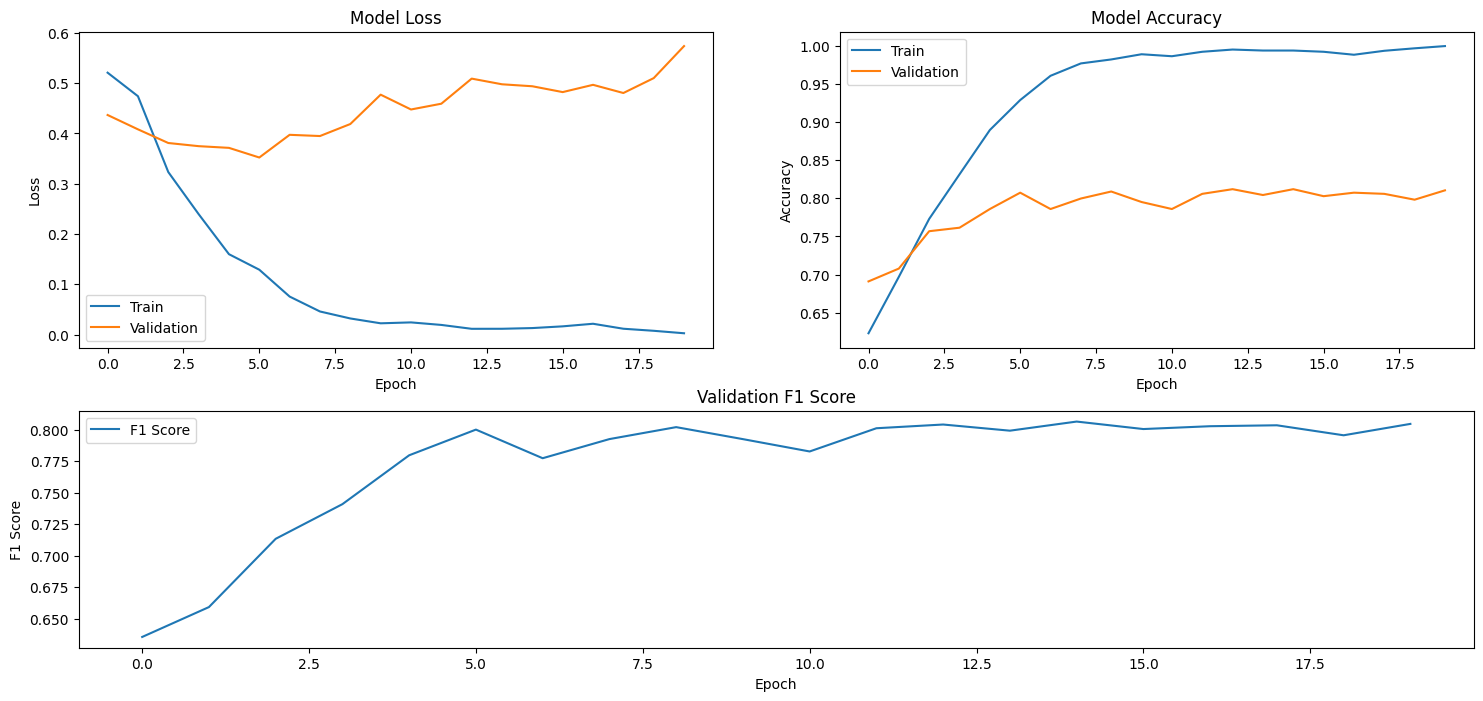

In [16]:
plot_training_process(lstm_history, lstm_f1_scores)

In [17]:
lstm_model, lstm_history, lstm_f1_scores = train_lstm_distilled(temperature=1.0, alpha=0.7)

accuracy,▁▂▄▅▆▇▇█████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▇▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
test_f1_score,▁
val_accuracy,▁▂▅▅▆█▆▇█▇▆████▇██▇█
val_f1_score,▁▂▄▅▇█▇▇█▇▇█████████
val_loss,▄▃▂▂▂▁▂▂▃▅▄▄▆▆▅▅▆▅▆█
accuracy,0.99935
best_epoch,5
best_val_loss,0.35211
epoch,19


82/82 [==============================] - 2s 26ms/step
Epoch 1/20

Calculating validation F1 score...
21/21 [==============================] - 1s 7ms/step
Epoch: 1 - validation_data f1_score: 0.5698
97/97 - 19s - loss: 0.5247 - accuracy: 0.6206 - val_loss: 0.4604 - val_accuracy: 0.6575 - 19s/epoch - 195ms/step
Epoch 2/20

Calculating validation F1 score...
21/21 [==============================] - 0s 7ms/step
Epoch: 2 - validation_data f1_score: 0.7047
97/97 - 7s - loss: 0.3764 - accuracy: 0.7357 - val_loss: 0.3914 - val_accuracy: 0.7462 - 7s/epoch - 70ms/step
Epoch 3/20

Calculating validation F1 score...
21/21 [==============================] - 0s 7ms/step
Epoch: 3 - validation_data f1_score: 0.6367
97/97 - 4s - loss: 0.2792 - accuracy: 0.8090 - val_loss: 0.4520 - val_accuracy: 0.6820 - 4s/epoch - 41ms/step
Epoch 4/20

Calculating validation F1 score...
21/21 [==============================] - 0s 6ms/step
Epoch: 4 - validation_data f1_score: 0.7114
97/97 - 3s - loss: 0.2614 - accuracy:

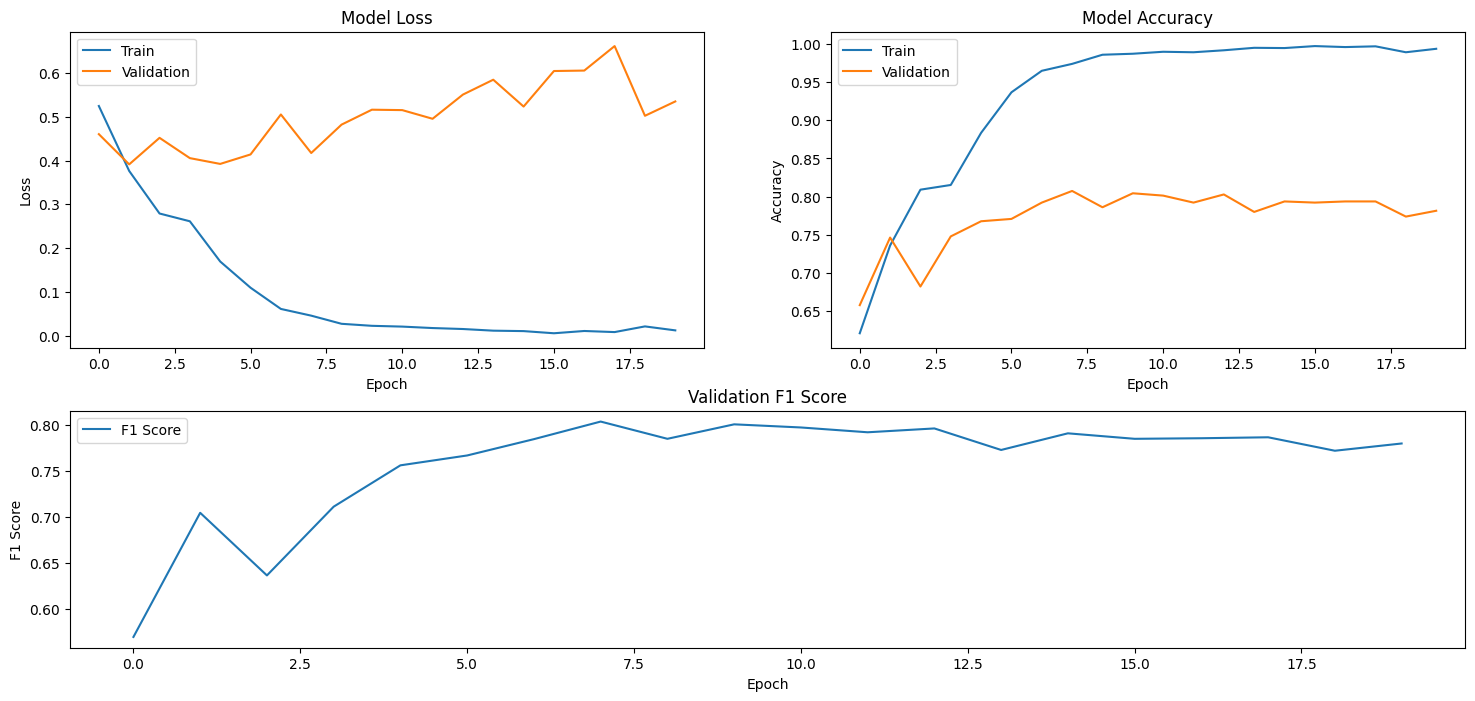

In [18]:
plot_training_process(lstm_history, lstm_f1_scores)

In [19]:
lstm_model, lstm_history, lstm_f1_scores = train_lstm_distilled(temperature=1.0, alpha=0.3)

accuracy,▁▃▅▅▆▇▇█████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
test_f1_score,▁
val_accuracy,▁▅▂▅▆▆▇█▇██▇█▇▇▇▇▇▆▇
val_f1_score,▁▅▃▅▇▇▇█▇████▇█▇▇▇▇▇
val_loss,▃▁▃▁▁▂▄▂▃▄▄▄▅▆▄▇▇█▄▅
accuracy,0.99384
best_epoch,1
best_val_loss,0.39136
epoch,19


82/82 [==============================] - 2s 26ms/step
Epoch 1/20

Calculating validation F1 score...
21/21 [==============================] - 1s 7ms/step
Epoch: 1 - validation_data f1_score: 0.6177
97/97 - 20s - loss: 0.5259 - accuracy: 0.6161 - val_loss: 0.4567 - val_accuracy: 0.6667 - 20s/epoch - 201ms/step
Epoch 2/20

Calculating validation F1 score...
21/21 [==============================] - 0s 7ms/step
Epoch: 2 - validation_data f1_score: 0.7056
97/97 - 6s - loss: 0.3806 - accuracy: 0.7299 - val_loss: 0.3866 - val_accuracy: 0.7446 - 6s/epoch - 63ms/step
Epoch 3/20

Calculating validation F1 score...
21/21 [==============================] - 0s 6ms/step
Epoch: 3 - validation_data f1_score: 0.7029
97/97 - 4s - loss: 0.2802 - accuracy: 0.8084 - val_loss: 0.3931 - val_accuracy: 0.7431 - 4s/epoch - 39ms/step
Epoch 4/20

Calculating validation F1 score...
21/21 [==============================] - 0s 7ms/step
Epoch: 4 - validation_data f1_score: 0.7353
97/97 - 4s - loss: 0.2096 - accuracy:

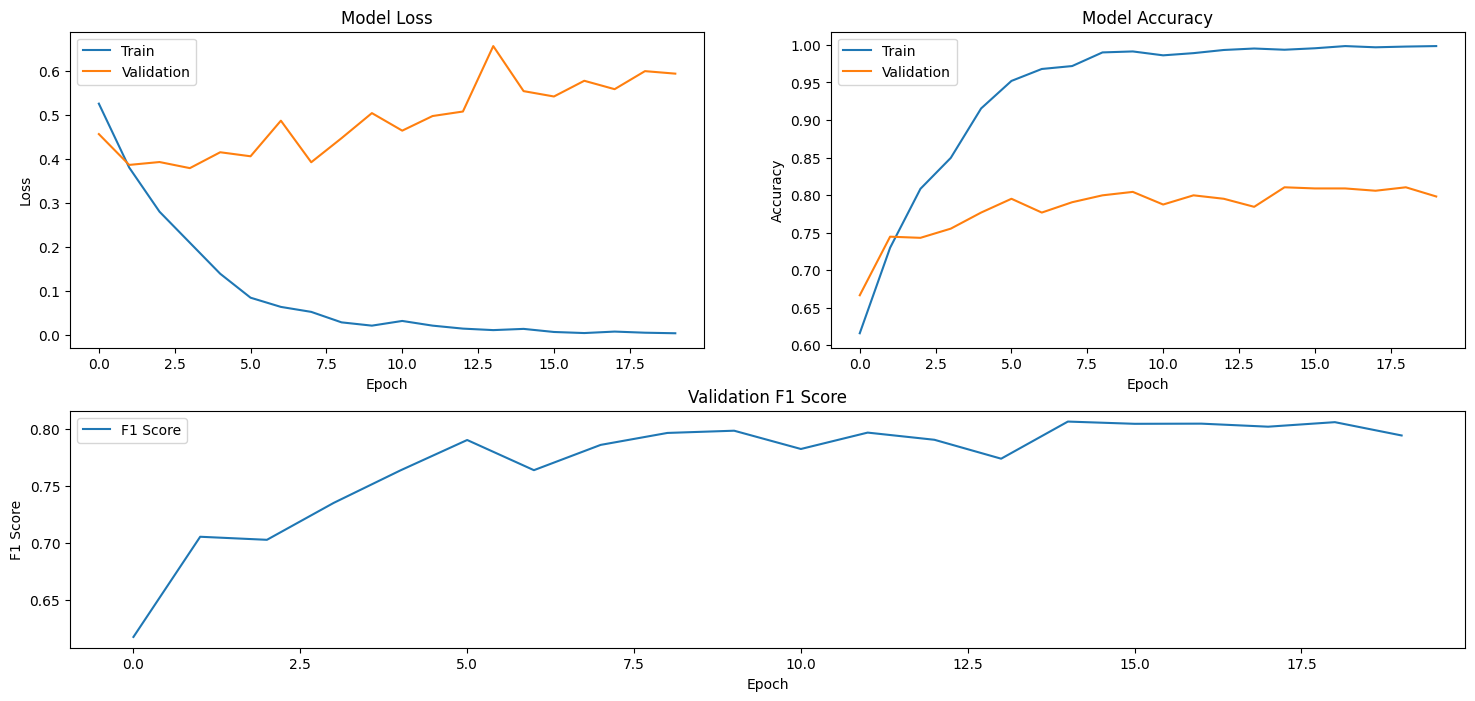

In [20]:
plot_training_process(lstm_history, lstm_f1_scores)

In [21]:
lstm_model, lstm_history, lstm_f1_scores = train_lstm_distilled(temperature=2.0, alpha=0.5)

accuracy,▁▃▅▅▆▇▇█████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
test_f1_score,▁
val_accuracy,▁▅▅▅▆▇▆▇▇█▇▇▇▇█████▇
val_f1_score,▁▄▄▅▆▇▆▇██▇█▇▇██████
val_loss,▃▁▁▁▂▂▄▁▃▄▃▄▄█▅▅▆▆▇▆
accuracy,0.99838
best_epoch,3
best_val_loss,0.37927
epoch,19


82/82 [==============================] - 2s 25ms/step
Epoch 1/20

Calculating validation F1 score...
21/21 [==============================] - 1s 7ms/step
Epoch: 1 - validation_data f1_score: 0.6295
97/97 - 19s - loss: 0.5150 - accuracy: 0.6352 - val_loss: 0.4491 - val_accuracy: 0.6942 - 19s/epoch - 192ms/step
Epoch 2/20

Calculating validation F1 score...
21/21 [==============================] - 0s 6ms/step
Epoch: 2 - validation_data f1_score: 0.6871
97/97 - 7s - loss: 0.3755 - accuracy: 0.7435 - val_loss: 0.3895 - val_accuracy: 0.7355 - 7s/epoch - 69ms/step
Epoch 3/20

Calculating validation F1 score...
21/21 [==============================] - 0s 7ms/step
Epoch: 3 - validation_data f1_score: 0.7029
97/97 - 5s - loss: 0.2817 - accuracy: 0.7980 - val_loss: 0.3979 - val_accuracy: 0.7416 - 5s/epoch - 49ms/step
Epoch 4/20

Calculating validation F1 score...
21/21 [==============================] - 0s 7ms/step
Epoch: 4 - validation_data f1_score: 0.7062
97/97 - 4s - loss: 0.2149 - accuracy:

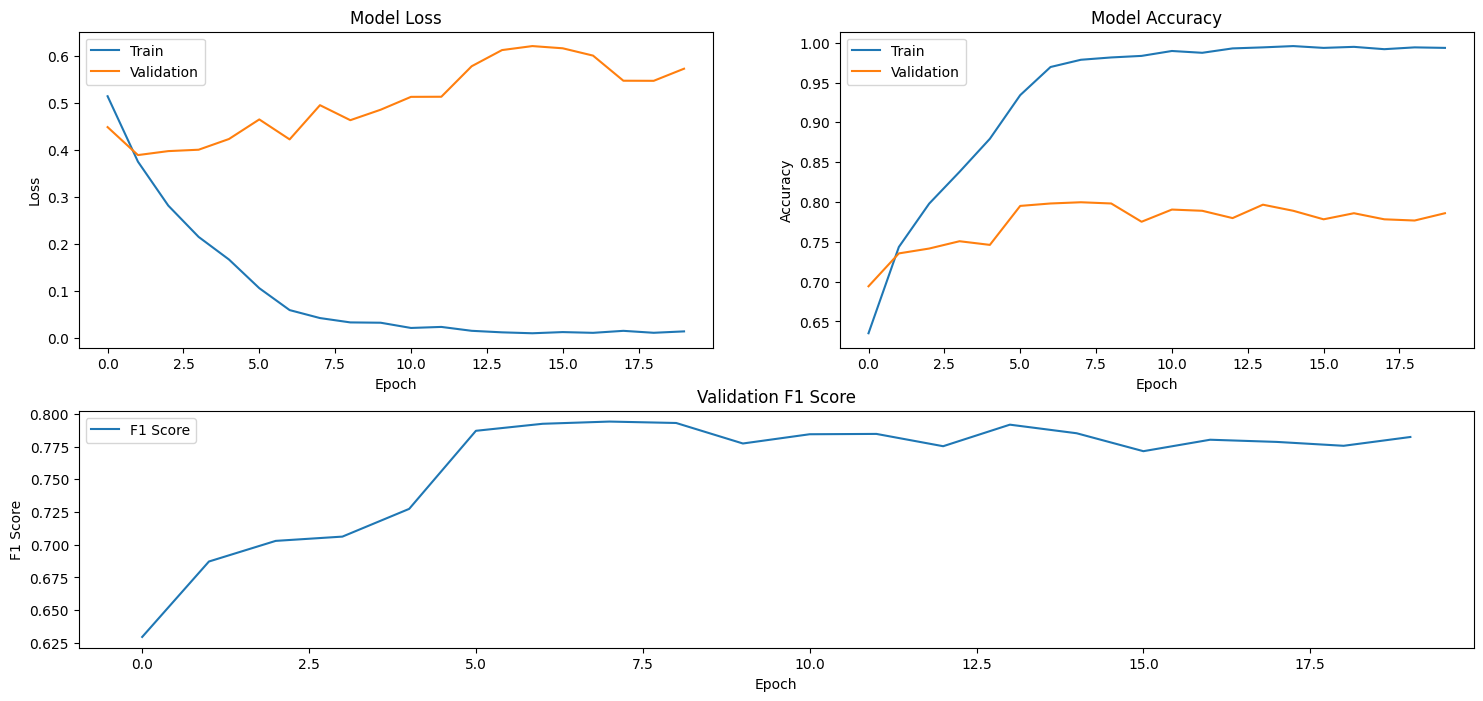

In [22]:
plot_training_process(lstm_history, lstm_f1_scores)

In [23]:
lstm_model, lstm_history, lstm_f1_scores = train_lstm_distilled(temperature=2.0, alpha=0.7)

accuracy,▁▃▄▅▆▇▇█████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
test_f1_score,▁
val_accuracy,▁▄▄▅▄████▆▇▇▇█▇▇▇▇▆▇
val_f1_score,▁▃▄▄▅████▇██▇██▇▇▇▇▇
val_loss,▃▁▁▁▂▃▂▄▃▄▅▅▇███▇▆▆▇
accuracy,0.99351
best_epoch,1
best_val_loss,0.38946
epoch,19


82/82 [==============================] - 2s 26ms/step
Epoch 1/20

Calculating validation F1 score...
21/21 [==============================] - 1s 7ms/step
Epoch: 1 - validation_data f1_score: 0.6135
97/97 - 20s - loss: 0.5145 - accuracy: 0.6310 - val_loss: 0.4516 - val_accuracy: 0.6758 - 20s/epoch - 204ms/step
Epoch 2/20

Calculating validation F1 score...
21/21 [==============================] - 0s 6ms/step
Epoch: 2 - validation_data f1_score: 0.7039
97/97 - 7s - loss: 0.3757 - accuracy: 0.7335 - val_loss: 0.3847 - val_accuracy: 0.7462 - 7s/epoch - 75ms/step
Epoch 3/20

Calculating validation F1 score...
21/21 [==============================] - 0s 6ms/step
Epoch: 3 - validation_data f1_score: 0.7136
97/97 - 5s - loss: 0.2760 - accuracy: 0.8129 - val_loss: 0.3838 - val_accuracy: 0.7508 - 5s/epoch - 49ms/step
Epoch 4/20

Calculating validation F1 score...
21/21 [==============================] - 0s 7ms/step
Epoch: 4 - validation_data f1_score: 0.7235
97/97 - 4s - loss: 0.2172 - accuracy:

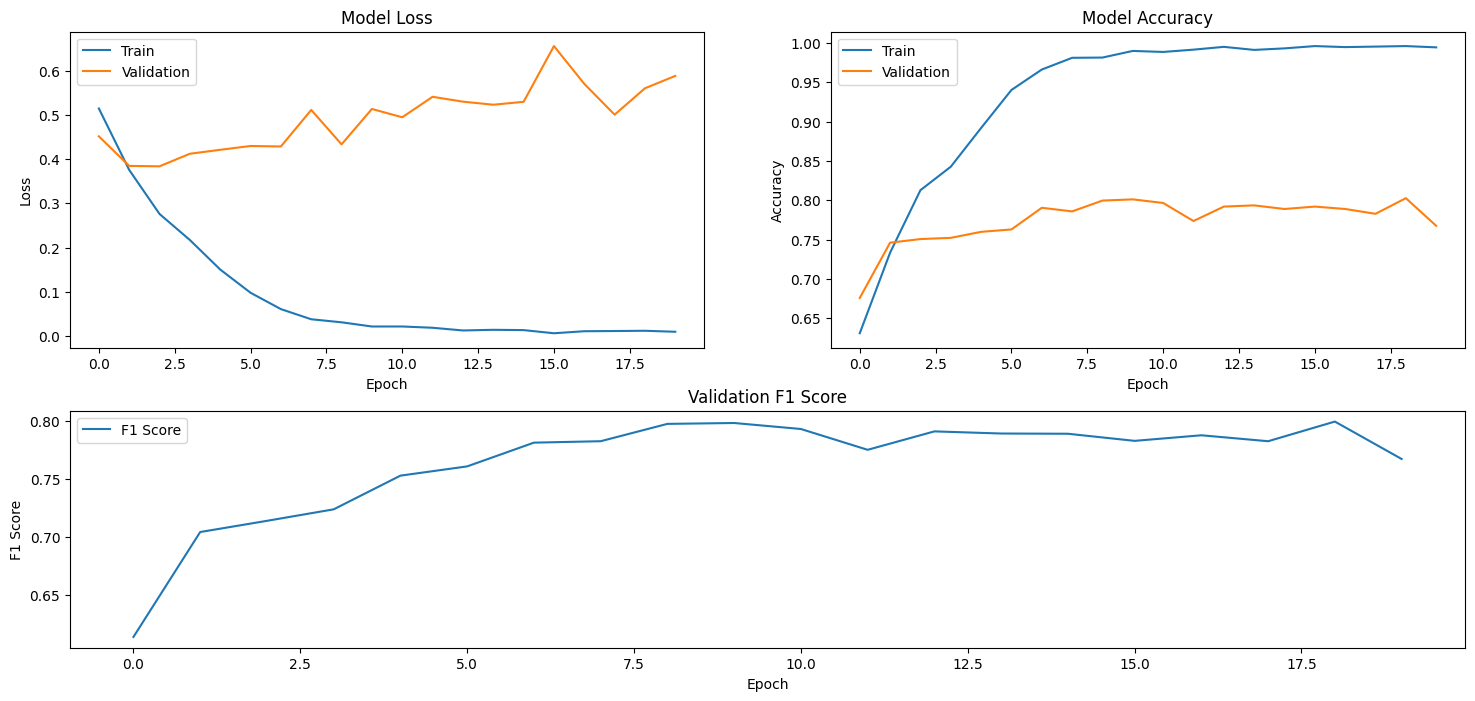

In [24]:
plot_training_process(lstm_history, lstm_f1_scores)

In [25]:
lstm_model, lstm_history, lstm_f1_scores = train_lstm_distilled(temperature=2.0, alpha=0.3)

accuracy,▁▃▄▅▆▇▇█████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
test_f1_score,▁
val_accuracy,▁▅▅▅▆▆▇▇███▆▇▇▇▇▇▇█▆
val_f1_score,▁▄▅▅▆▇▇▇███▇███▇█▇█▇
val_loss,▃▁▁▂▂▂▂▄▂▄▄▅▅▅▅█▆▄▆▆
accuracy,0.99449
best_epoch,2
best_val_loss,0.38378
epoch,19


82/82 [==============================] - 2s 26ms/step
Epoch 1/20

Calculating validation F1 score...
21/21 [==============================] - 1s 7ms/step
Epoch: 1 - validation_data f1_score: 0.6292
97/97 - 18s - loss: 0.5300 - accuracy: 0.6219 - val_loss: 0.4625 - val_accuracy: 0.6743 - 18s/epoch - 184ms/step
Epoch 2/20

Calculating validation F1 score...
21/21 [==============================] - 0s 7ms/step
Epoch: 2 - validation_data f1_score: 0.6797
97/97 - 6s - loss: 0.3814 - accuracy: 0.7292 - val_loss: 0.4033 - val_accuracy: 0.7309 - 6s/epoch - 67ms/step
Epoch 3/20

Calculating validation F1 score...
21/21 [==============================] - 0s 6ms/step
Epoch: 3 - validation_data f1_score: 0.7162
97/97 - 5s - loss: 0.2808 - accuracy: 0.8090 - val_loss: 0.3832 - val_accuracy: 0.7554 - 5s/epoch - 55ms/step
Epoch 4/20

Calculating validation F1 score...
21/21 [==============================] - 0s 6ms/step
Epoch: 4 - validation_data f1_score: 0.7602
97/97 - 3s - loss: 0.2093 - accuracy:

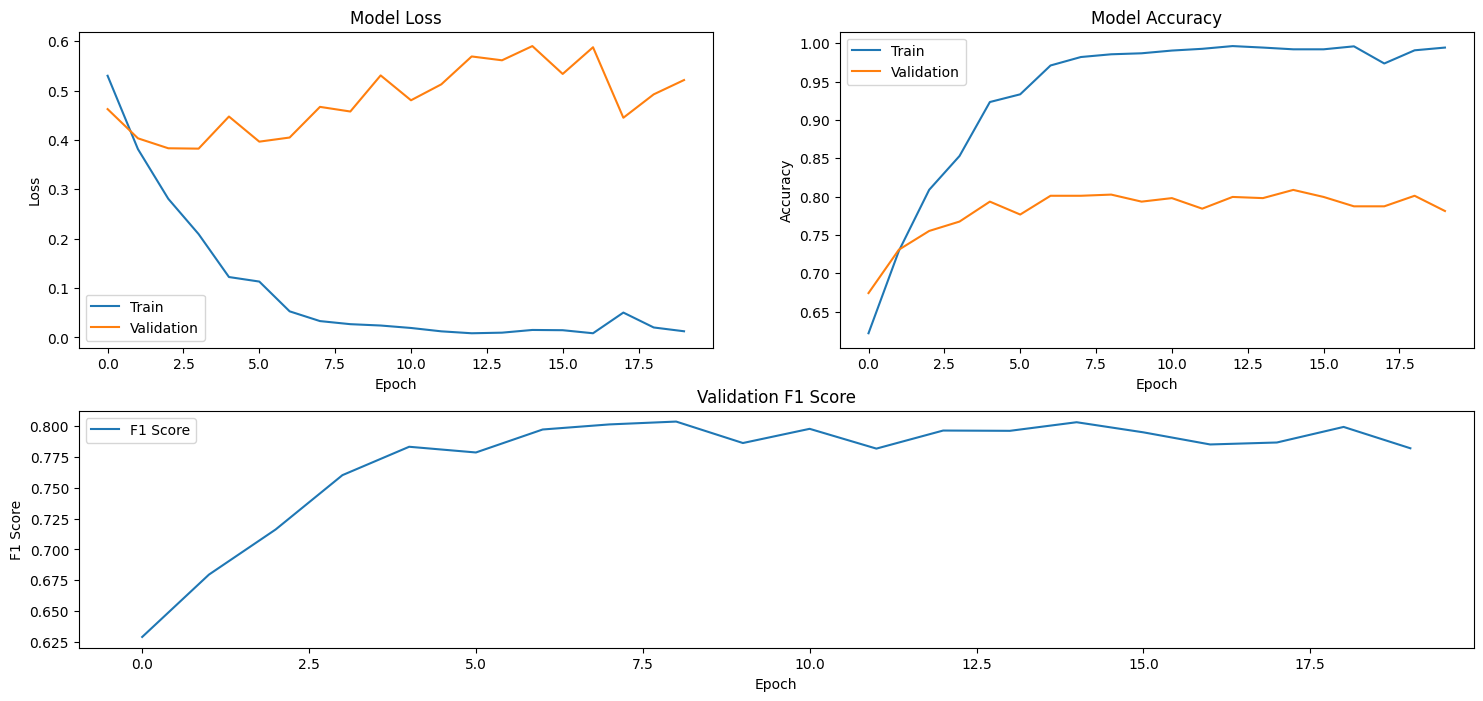

In [26]:
plot_training_process(lstm_history, lstm_f1_scores)

In [27]:
lstm_model, lstm_history, lstm_f1_scores = train_lstm_distilled(temperature=5.0, alpha=0.5)

accuracy,▁▃▄▅▇▇██████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁
test_f1_score,▁
val_accuracy,▁▄▅▆▇▆███▇▇▇█▇██▇▇█▇
val_f1_score,▁▃▄▆▇▇███▇█▇████▇▇█▇
val_loss,▄▂▁▁▃▁▂▄▄▆▄▅▇▇█▆█▃▅▆
accuracy,0.99449
best_epoch,3
best_val_loss,0.3824
epoch,19


82/82 [==============================] - 2s 26ms/step
Epoch 1/20

Calculating validation F1 score...
21/21 [==============================] - 1s 6ms/step
Epoch: 1 - validation_data f1_score: 0.6199
97/97 - 21s - loss: 0.5135 - accuracy: 0.6362 - val_loss: 0.4512 - val_accuracy: 0.6865 - 21s/epoch - 216ms/step
Epoch 2/20

Calculating validation F1 score...
21/21 [==============================] - 0s 7ms/step
Epoch: 2 - validation_data f1_score: 0.6743
97/97 - 7s - loss: 0.4010 - accuracy: 0.7134 - val_loss: 0.4101 - val_accuracy: 0.7171 - 7s/epoch - 71ms/step
Epoch 3/20

Calculating validation F1 score...
21/21 [==============================] - 0s 7ms/step
Epoch: 3 - validation_data f1_score: 0.7163
97/97 - 3s - loss: 0.3166 - accuracy: 0.7798 - val_loss: 0.3766 - val_accuracy: 0.7523 - 3s/epoch - 34ms/step
Epoch 4/20

Calculating validation F1 score...
21/21 [==============================] - 0s 7ms/step
Epoch: 4 - validation_data f1_score: 0.7015
97/97 - 4s - loss: 0.2348 - accuracy:

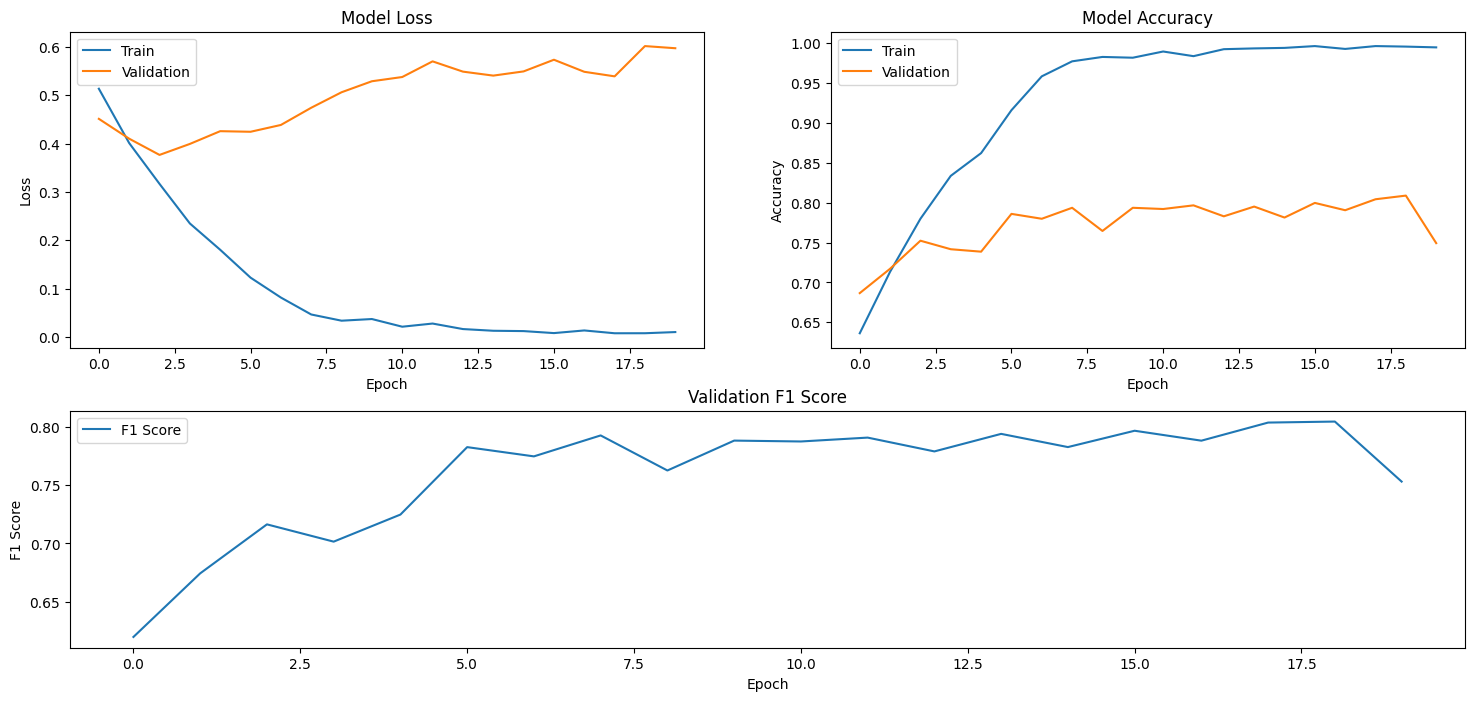

In [28]:
plot_training_process(lstm_history, lstm_f1_scores)

In [29]:
lstm_model, lstm_history, lstm_f1_scores = train_lstm_distilled(temperature=5.0, alpha=0.7)

accuracy,▁▂▄▅▅▆▇█████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
test_f1_score,▁
val_accuracy,▁▃▅▄▄▇▆▇▅▇▇▇▇▇▆▇▇██▅
val_f1_score,▁▃▅▄▅▇▇█▆▇▇▇▇█▇█▇██▆
val_loss,▃▂▁▂▃▂▃▄▅▆▆▇▆▆▆▇▆▆██
accuracy,0.99481
best_epoch,2
best_val_loss,0.37657
epoch,19


82/82 [==============================] - 2s 25ms/step
Epoch 1/20

Calculating validation F1 score...
21/21 [==============================] - 1s 7ms/step
Epoch: 1 - validation_data f1_score: 0.6251
97/97 - 19s - loss: 0.5198 - accuracy: 0.6235 - val_loss: 0.4500 - val_accuracy: 0.6774 - 19s/epoch - 198ms/step
Epoch 2/20

Calculating validation F1 score...
21/21 [==============================] - 0s 6ms/step
Epoch: 2 - validation_data f1_score: 0.7063
97/97 - 6s - loss: 0.3863 - accuracy: 0.7202 - val_loss: 0.3871 - val_accuracy: 0.7508 - 6s/epoch - 62ms/step
Epoch 3/20

Calculating validation F1 score...
21/21 [==============================] - 0s 7ms/step
Epoch: 3 - validation_data f1_score: 0.7002
97/97 - 5s - loss: 0.2786 - accuracy: 0.8077 - val_loss: 0.4008 - val_accuracy: 0.7401 - 5s/epoch - 49ms/step
Epoch 4/20

Calculating validation F1 score...
21/21 [==============================] - 0s 7ms/step
Epoch: 4 - validation_data f1_score: 0.7350
97/97 - 4s - loss: 0.2078 - accuracy:

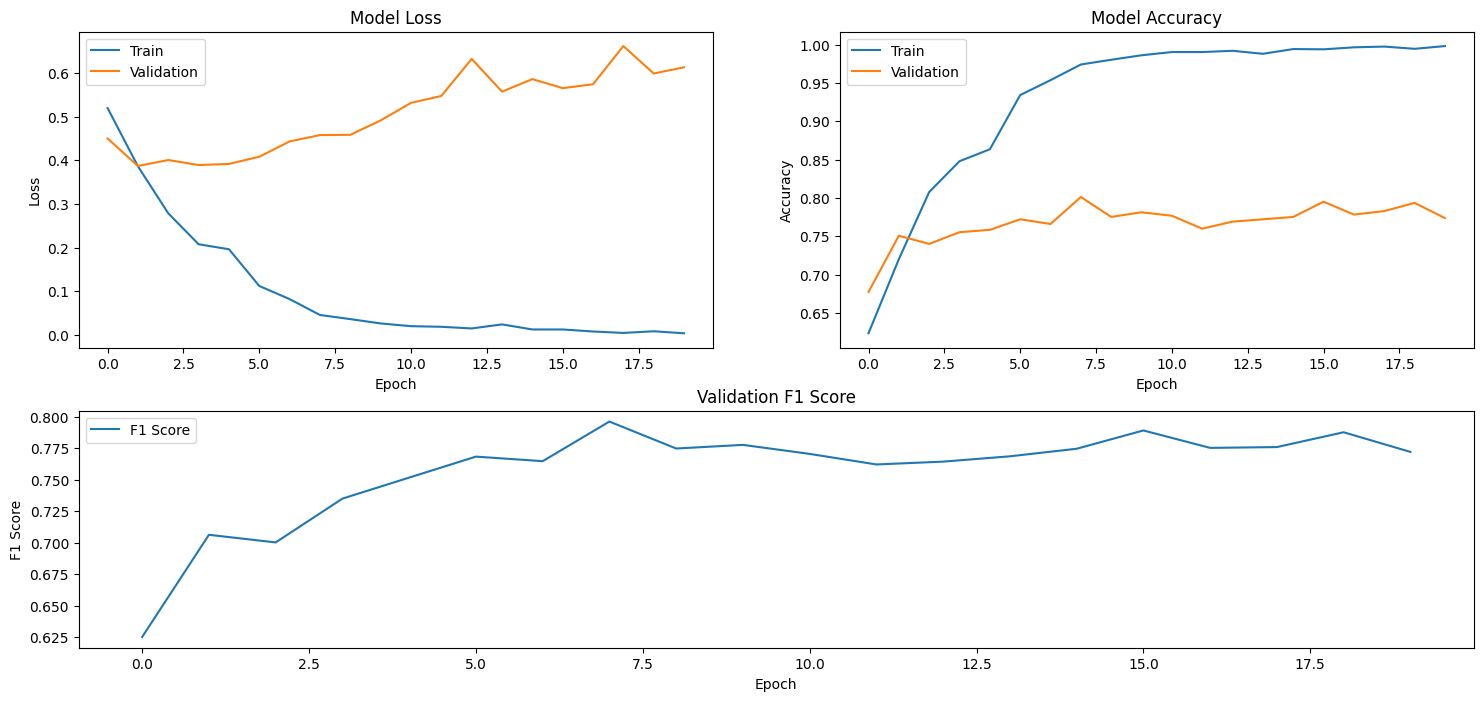

In [30]:
plot_training_process(lstm_history, lstm_f1_scores)

In [31]:
lstm_model, lstm_history, lstm_f1_scores = train_lstm_distilled(temperature=5.0, alpha=0.3)

accuracy,▁▃▄▅▅▇▇█████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▄▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
test_f1_score,▁
val_accuracy,▁▅▅▅▆▆▆█▇▇▇▆▆▆▇█▇▇█▆
val_f1_score,▁▄▄▅▆▇▇█▇▇▇▇▇▇▇█▇▇█▇
val_loss,▃▁▁▁▁▂▂▃▃▄▅▅▇▅▆▆▆█▆▇
accuracy,0.99805
best_epoch,1
best_val_loss,0.38707
epoch,19


82/82 [==============================] - 2s 26ms/step
Epoch 1/20

Calculating validation F1 score...
21/21 [==============================] - 1s 6ms/step
Epoch: 1 - validation_data f1_score: 0.6285
97/97 - 20s - loss: 0.5185 - accuracy: 0.6326 - val_loss: 0.4560 - val_accuracy: 0.6636 - 20s/epoch - 203ms/step
Epoch 2/20

Calculating validation F1 score...
21/21 [==============================] - 0s 7ms/step
Epoch: 2 - validation_data f1_score: 0.6945
97/97 - 7s - loss: 0.3772 - accuracy: 0.7357 - val_loss: 0.3863 - val_accuracy: 0.7401 - 7s/epoch - 74ms/step
Epoch 3/20

Calculating validation F1 score...
21/21 [==============================] - 0s 7ms/step
Epoch: 3 - validation_data f1_score: 0.7033
97/97 - 4s - loss: 0.2742 - accuracy: 0.8054 - val_loss: 0.3902 - val_accuracy: 0.7355 - 4s/epoch - 43ms/step
Epoch 4/20

Calculating validation F1 score...
21/21 [==============================] - 0s 6ms/step
Epoch: 4 - validation_data f1_score: 0.7145
97/97 - 4s - loss: 0.2177 - accuracy:

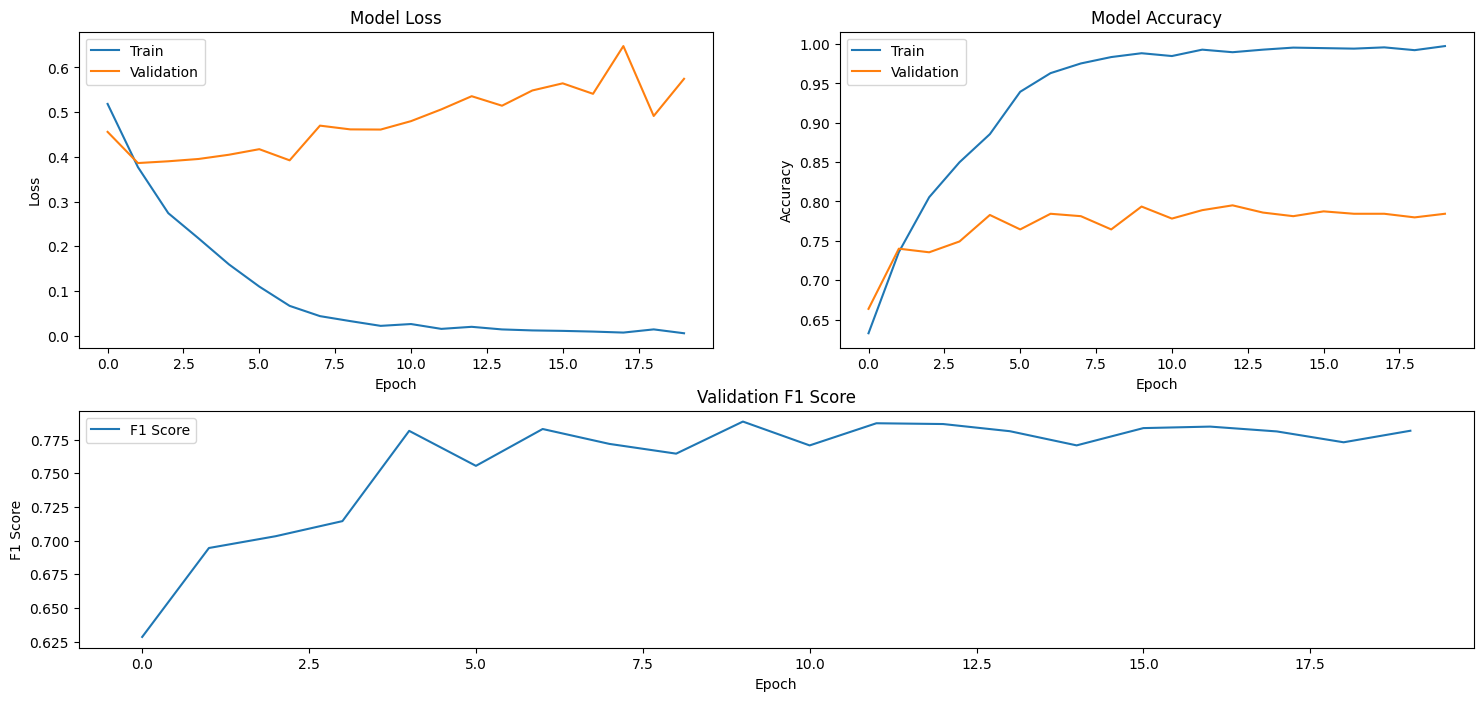

In [32]:
plot_training_process(lstm_history, lstm_f1_scores)

# BERT

In [15]:
distillbert_model, distillbert_history, distillbert_f1_scores = train_bert_distilled(temperature=1.0, alpha=0.5)

wandb: Currently logged in as: iankelk. Use `wandb login --relogin` to force relogin


82/82 [==============================] - 5s 30ms/step
Epoch 1/20
386/386 [==============================] - ETA: 0s - loss: 0.8839 - accuracy: 0.6093
Calculating validation F1 score...
Epoch: 1 - validation_data f1_score: 0.5808
386/386 [==============================] - 70s 118ms/step - loss: 0.8839 - accuracy: 0.6093 - val_loss: 0.7306 - val_accuracy: 0.6820
Epoch 2/20
386/386 [==============================] - ETA: 0s - loss: 0.7339 - accuracy: 0.6829
Calculating validation F1 score...
Epoch: 2 - validation_data f1_score: 0.6232
386/386 [==============================] - 26s 67ms/step - loss: 0.7339 - accuracy: 0.6829 - val_loss: 0.7235 - val_accuracy: 0.7141
Epoch 3/20
386/386 [==============================] - ETA: 0s - loss: 0.5966 - accuracy: 0.7481
Calculating validation F1 score...
Epoch: 3 - validation_data f1_score: 0.6022
386/386 [==============================] - 26s 66ms/step - loss: 0.5966 - accuracy: 0.7481 - val_loss: 0.8459 - val_accuracy: 0.6789
Epoch 4/20
385/386 [=

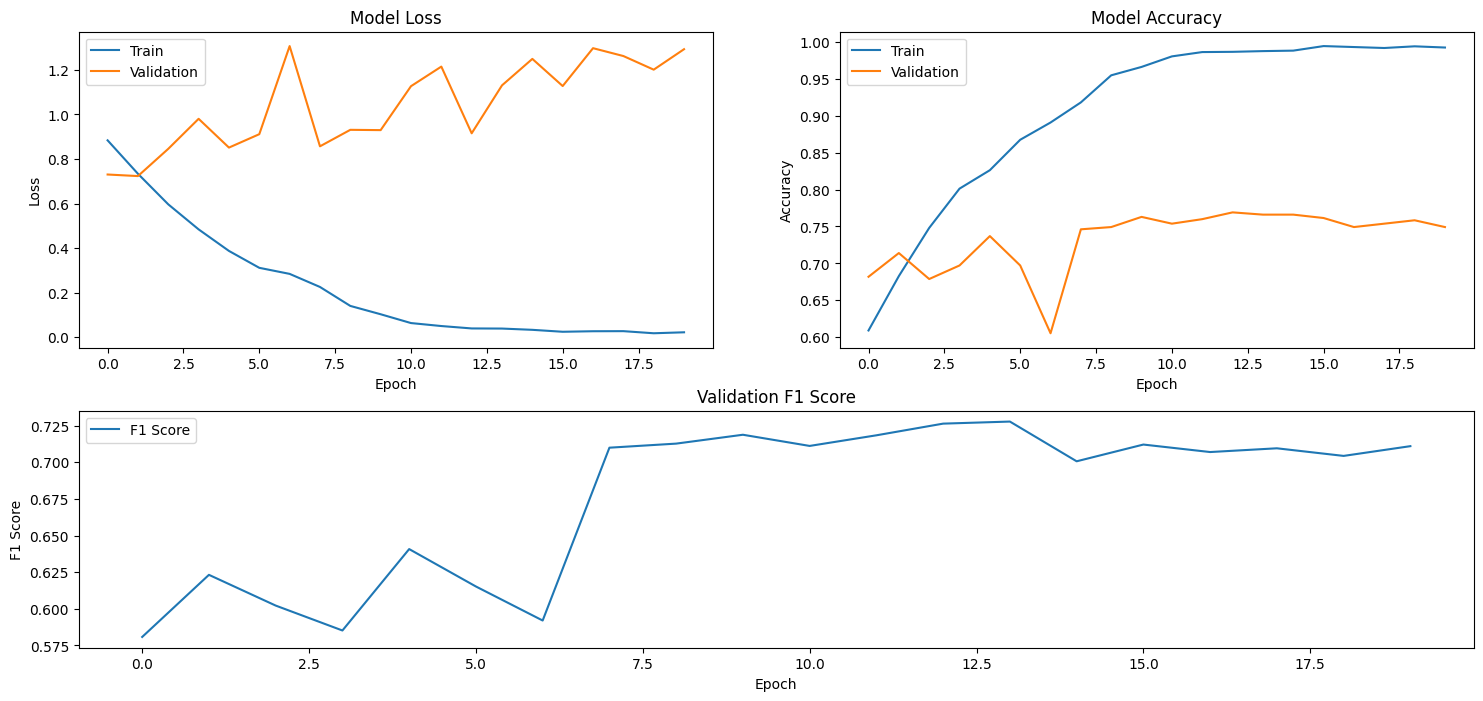

In [16]:
plot_training_process(distillbert_history, distillbert_f1_scores)

In [ ]:
distillbert_model, distillbert_history, distillbert_f1_scores = train_bert_distilled(temperature=1.0, alpha=0.8)

accuracy,▁▂▄▅▅▆▆▇▇▇██████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
f1_score,▁
loss,█▇▆▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▂▄▆▃▅▇████▇█▇▇▇▇▆
val_f1_score,▁▄▅▂▄▆▅▇▇█▇██▇█▇▇▇▇▇
val_loss,▂▁▁▅▂▃▄▄▃▅▆▆▅▆▆▇█▆▇█
accuracy,0.99481
best_epoch,2
best_val_loss,0.66374
epoch,19


82/82 [==============================] - 2s 30ms/step
Epoch 1/20
386/386 [==============================] - ETA: 0s - loss: 0.8848 - accuracy: 0.6093
Calculating validation F1 score...
Epoch: 1 - validation_data f1_score: 0.5658
386/386 [==============================] - 65s 107ms/step - loss: 0.8848 - accuracy: 0.6093 - val_loss: 0.7397 - val_accuracy: 0.6758
Epoch 2/20
385/386 [============================>.] - ETA: 0s - loss: 0.7321 - accuracy: 0.6769
Calculating validation F1 score...
Epoch: 2 - validation_data f1_score: 0.6351
386/386 [==============================] - 26s 67ms/step - loss: 0.7320 - accuracy: 0.6767 - val_loss: 0.6700 - val_accuracy: 0.7278
Epoch 3/20
386/386 [==============================] - ETA: 0s - loss: 0.5901 - accuracy: 0.7549
Calculating validation F1 score...
Epoch: 3 - validation_data f1_score: 0.6272
386/386 [==============================] - 26s 67ms/step - loss: 0.5901 - accuracy: 0.7549 - val_loss: 0.7479 - val_accuracy: 0.7003
Epoch 4/20
385/386 [=

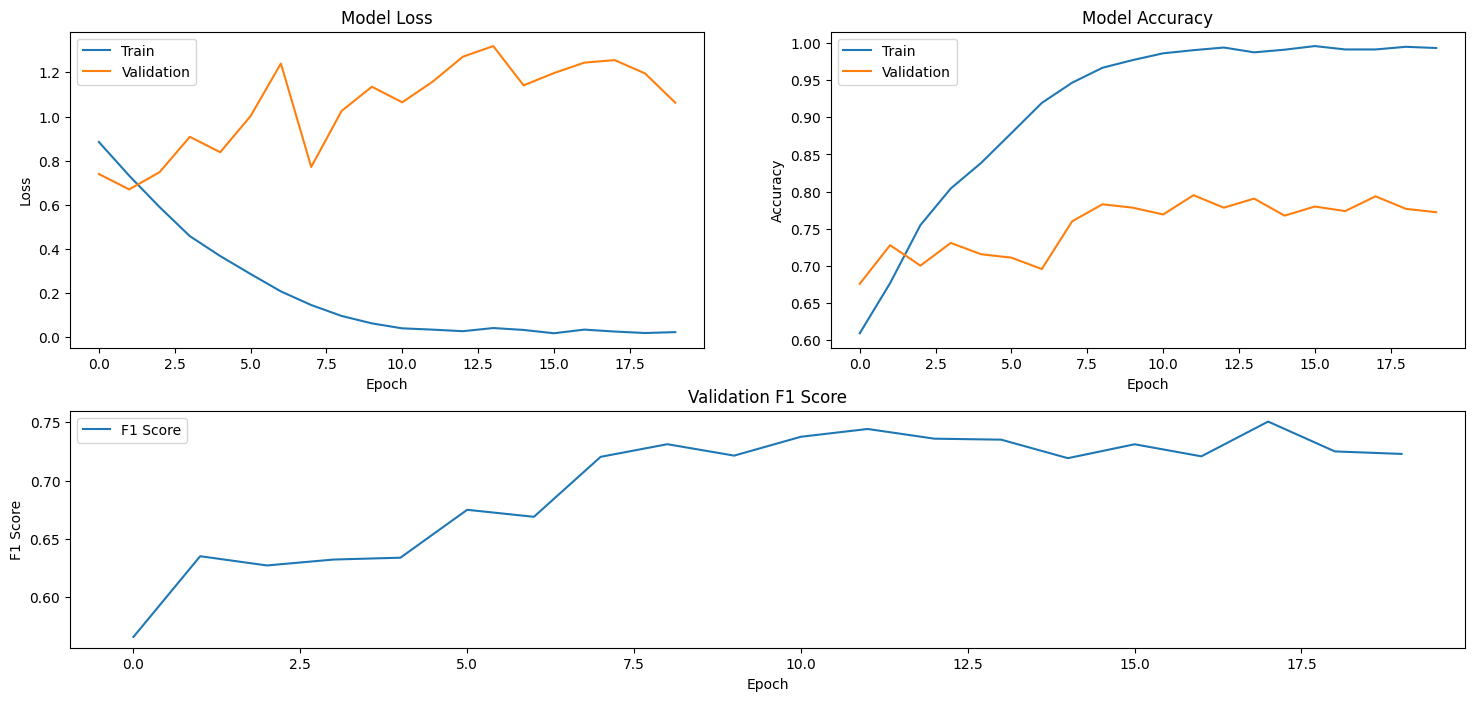

In [ ]:
plot_training_process(distillbert_history, distillbert_f1_scores)

accuracy,▁▂▄▄▅▆▆▇▇▇██████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
f1_score,▁
loss,█▇▆▅▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▄▆▄▅▇▅▁▇▇█▇█████▇▇█▇
val_f1_score,▁▃▂▁▄▃▂▇▇█▇███▇▇▇▇▇▇
val_loss,▁▁▂▄▃▃█▃▃▃▆▇▃▆▇▆█▇▇█
accuracy,0.99222
best_epoch,1
best_val_loss,0.72353
epoch,19


82/82 [==============================] - 3s 30ms/step
Epoch 1/20
386/386 [==============================] - ETA: 0s - loss: 0.8765 - accuracy: 0.6141
Calculating validation F1 score...
Epoch: 1 - validation_data f1_score: 0.5646
386/386 [==============================] - 62s 102ms/step - loss: 0.8765 - accuracy: 0.6141 - val_loss: 0.7383 - val_accuracy: 0.6758
Epoch 2/20
386/386 [==============================] - ETA: 0s - loss: 0.7278 - accuracy: 0.6809
Calculating validation F1 score...
Epoch: 2 - validation_data f1_score: 0.6288
386/386 [==============================] - 25s 64ms/step - loss: 0.7278 - accuracy: 0.6809 - val_loss: 0.6581 - val_accuracy: 0.7141
Epoch 3/20
386/386 [==============================] - ETA: 0s - loss: 0.5823 - accuracy: 0.7497
Calculating validation F1 score...
Epoch: 3 - validation_data f1_score: 0.5951
386/386 [==============================] - 25s 64ms/step - loss: 0.5823 - accuracy: 0.7497 - val_loss: 0.7840 - val_accuracy: 0.6544
Epoch 4/20
385/386 [=

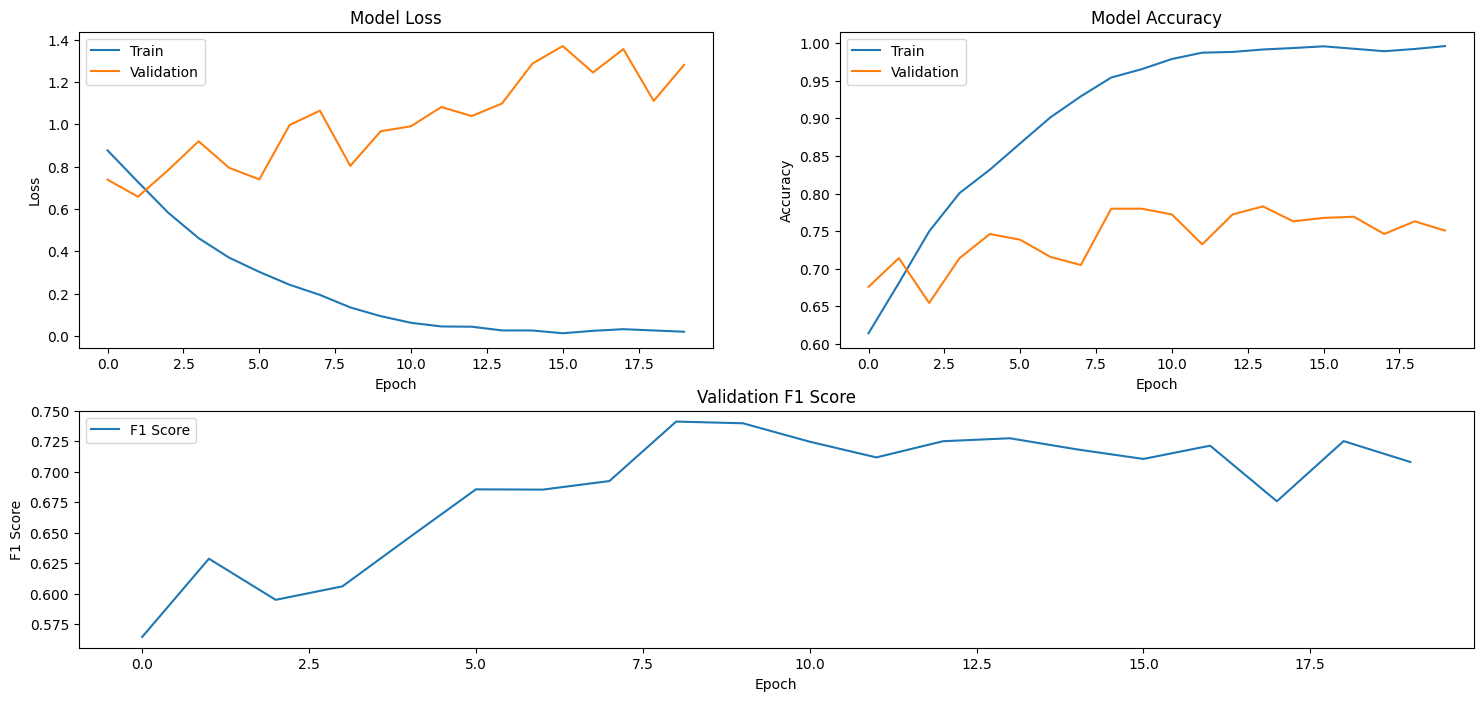

In [17]:
distillbert_model, distillbert_history, distillbert_f1_scores = train_bert_distilled(temperature=1.0, alpha=0.2)
plot_training_process(distillbert_history, distillbert_f1_scores)

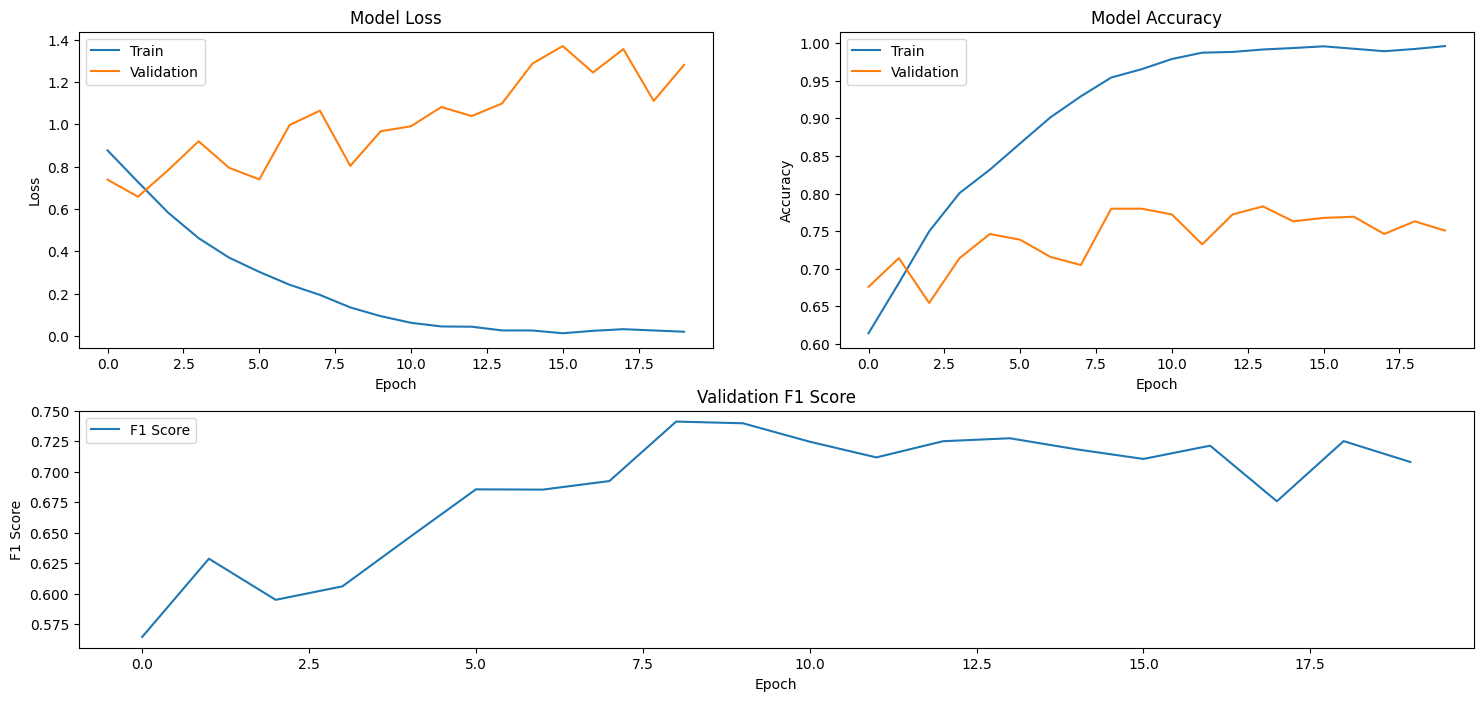

In [18]:
plot_training_process(distillbert_history, distillbert_f1_scores)

In [ ]:
distillbert_model, distillbert_history, distillbert_f1_scores = train_bert_distilled(temperature=2.0, alpha=0.5)

accuracy,▁▂▄▅▆▆▇▇▇███████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
f1_score,▁
loss,█▇▆▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▂▆▆▇▅▃▇▆▇▅▇▇▇▇█▇▇▇
val_f1_score,▁▅▄▅▇▇▇▆███▇████████
val_loss,▂▁▃▂▄▄▅▅▅▄▇▆▆██▇▆▇▇▇
accuracy,0.99611
best_epoch,1
best_val_loss,0.65567
epoch,19


82/82 [==============================] - 3s 31ms/step
Epoch 1/20
386/386 [==============================] - ETA: 0s - loss: 0.8113 - accuracy: 0.6119
Calculating validation F1 score...
Epoch: 1 - validation_data f1_score: 0.5577
386/386 [==============================] - 63s 106ms/step - loss: 0.8113 - accuracy: 0.6119 - val_loss: 0.6620 - val_accuracy: 0.6697
Epoch 2/20
385/386 [============================>.] - ETA: 0s - loss: 0.6694 - accuracy: 0.6812
Calculating validation F1 score...
Epoch: 2 - validation_data f1_score: 0.6265
386/386 [==============================] - 26s 68ms/step - loss: 0.6695 - accuracy: 0.6809 - val_loss: 0.5941 - val_accuracy: 0.7187
Epoch 3/20
386/386 [==============================] - ETA: 0s - loss: 0.5430 - accuracy: 0.7474
Calculating validation F1 score...
Epoch: 3 - validation_data f1_score: 0.6131
386/386 [==============================] - 26s 67ms/step - loss: 0.5430 - accuracy: 0.7474 - val_loss: 0.6318 - val_accuracy: 0.7187
Epoch 4/20
385/386 [=

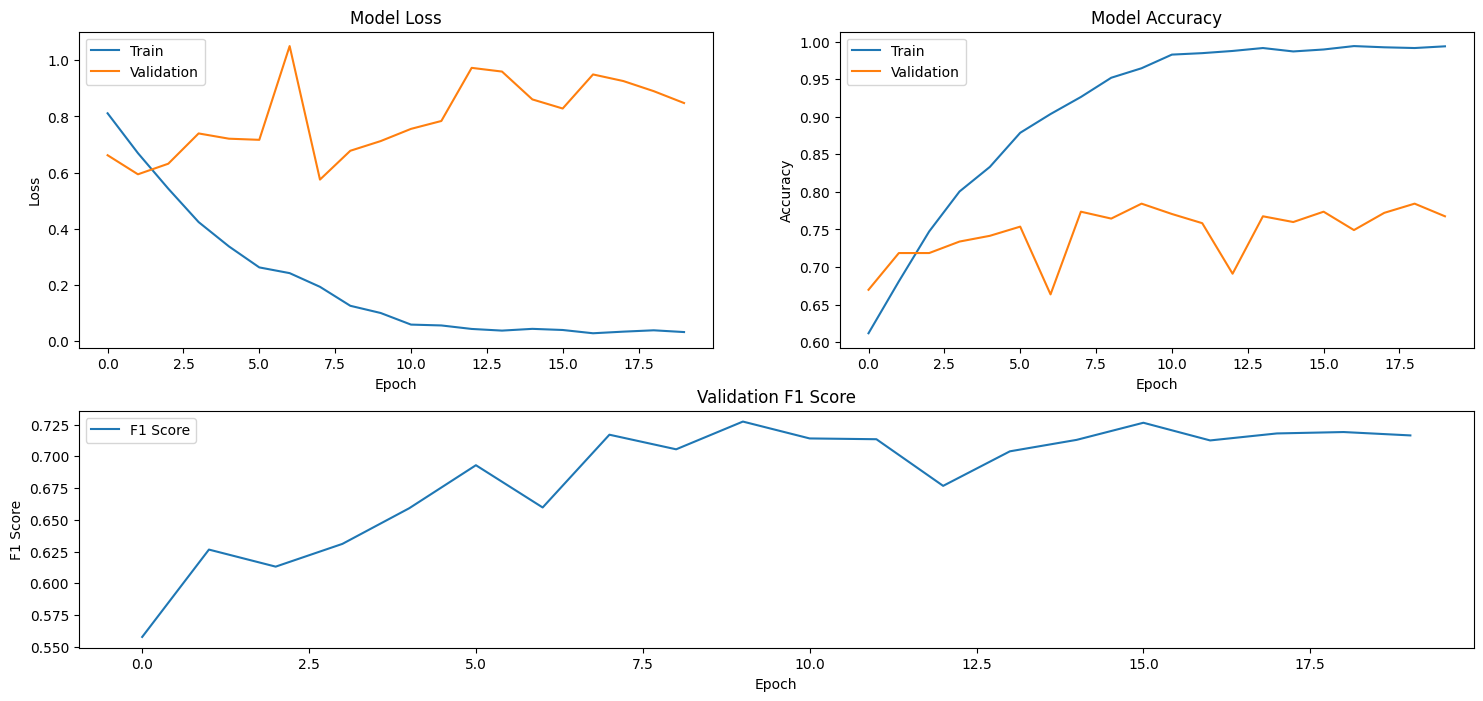

In [ ]:
plot_training_process(distillbert_history, distillbert_f1_scores)

In [ ]:
distillbert_model, distillbert_history, distillbert_f1_scores = train_bert_distilled(temperature=2.0, alpha=0.8)

accuracy,▁▂▃▄▅▆▆▇▇▇██████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
f1_score,▁
loss,█▇▆▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▄▅▆▆▁▇▇█▇▆▃▇▇▇▆▇█▇
val_f1_score,▁▄▃▄▅▇▅█▇█▇▇▆▇▇█▇███
val_loss,▂▁▂▃▃▃█▁▃▃▄▄▇▇▅▅▇▆▆▅
accuracy,0.99384
best_epoch,7
best_val_loss,0.57529
epoch,19


82/82 [==============================] - 2s 30ms/step
Epoch 1/20
386/386 [==============================] - ETA: 0s - loss: 0.8017 - accuracy: 0.6141
Calculating validation F1 score...
Epoch: 1 - validation_data f1_score: 0.5801
386/386 [==============================] - 65s 106ms/step - loss: 0.8017 - accuracy: 0.6141 - val_loss: 0.6362 - val_accuracy: 0.6789
Epoch 2/20
386/386 [==============================] - ETA: 0s - loss: 0.6560 - accuracy: 0.6858
Calculating validation F1 score...
Epoch: 2 - validation_data f1_score: 0.6311
386/386 [==============================] - 25s 66ms/step - loss: 0.6560 - accuracy: 0.6858 - val_loss: 0.5912 - val_accuracy: 0.7278
Epoch 3/20
386/386 [==============================] - ETA: 0s - loss: 0.5387 - accuracy: 0.7532
Calculating validation F1 score...
Epoch: 3 - validation_data f1_score: 0.5640
386/386 [==============================] - 25s 66ms/step - loss: 0.5387 - accuracy: 0.7532 - val_loss: 0.7649 - val_accuracy: 0.6758
Epoch 4/20
385/386 [=

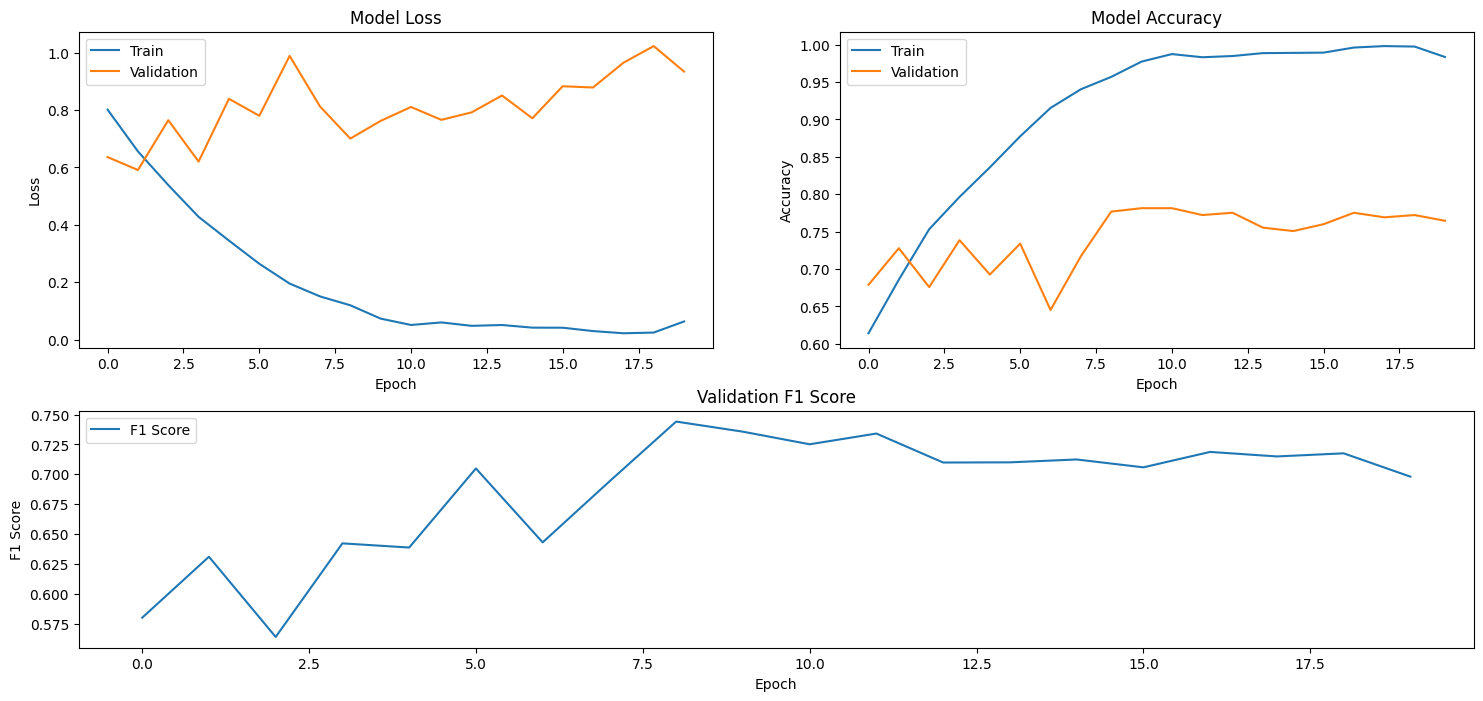

In [ ]:
plot_training_process(distillbert_history, distillbert_f1_scores)

In [ ]:
distillbert_model, distillbert_history, distillbert_f1_scores = train_bert_distilled(temperature=2.0, alpha=0.2)

accuracy,▁▂▄▄▅▆▆▇▇███████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
f1_score,▁
loss,█▇▆▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▃▅▃▆▃▆▁▅█████▇▆▇█▇█▇
val_f1_score,▂▄▁▄▄▆▄▆██▇█▇▇▇▇▇▇▇▆
val_loss,▂▁▄▁▅▄▇▅▃▄▅▄▄▅▄▆▆▇█▇
accuracy,0.98346
best_epoch,1
best_val_loss,0.59124
epoch,19


82/82 [==============================] - 2s 30ms/step
Epoch 1/20
386/386 [==============================] - ETA: 0s - loss: 0.8120 - accuracy: 0.6122
Calculating validation F1 score...
Epoch: 1 - validation_data f1_score: 0.5647
386/386 [==============================] - 63s 105ms/step - loss: 0.8120 - accuracy: 0.6122 - val_loss: 0.6597 - val_accuracy: 0.6743
Epoch 2/20
385/386 [============================>.] - ETA: 0s - loss: 0.6701 - accuracy: 0.6808
Calculating validation F1 score...
Epoch: 2 - validation_data f1_score: 0.6330
386/386 [==============================] - 27s 69ms/step - loss: 0.6705 - accuracy: 0.6806 - val_loss: 0.5892 - val_accuracy: 0.7095
Epoch 3/20
386/386 [==============================] - ETA: 0s - loss: 0.5307 - accuracy: 0.7523
Calculating validation F1 score...
Epoch: 3 - validation_data f1_score: 0.6510
386/386 [==============================] - 26s 67ms/step - loss: 0.5307 - accuracy: 0.7523 - val_loss: 0.5798 - val_accuracy: 0.7416
Epoch 4/20
385/386 [=

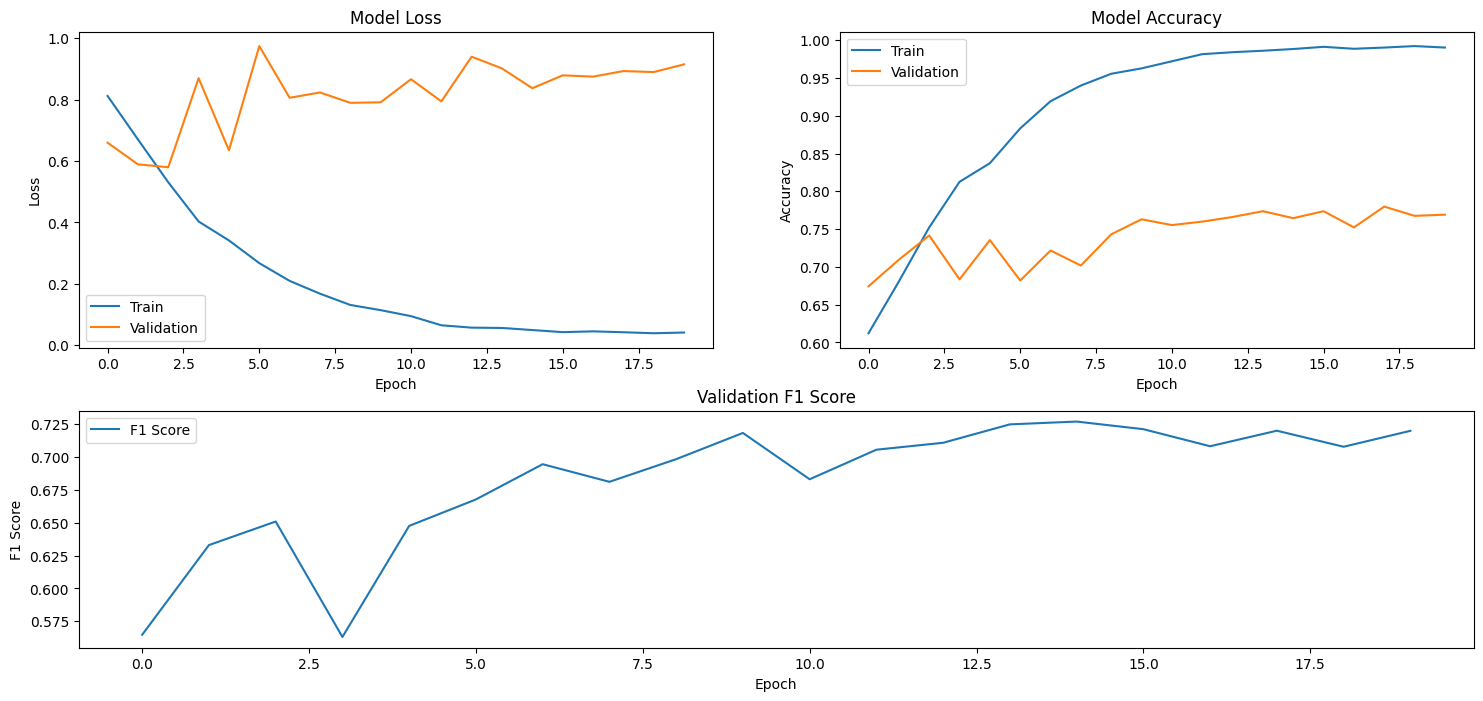

In [ ]:
plot_training_process(distillbert_history, distillbert_f1_scores)

In [ ]:
distillbert_model, distillbert_history, distillbert_f1_scores = train_bert_distilled(temperature=3.0, alpha=0.5)

accuracy,▁▂▄▅▅▆▇▇▇▇██████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
f1_score,▁
loss,█▇▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅▂▅▂▄▃▆▇▆▇▇█▇█▆█▇▇
val_f1_score,▁▄▅▁▅▅▇▆▇█▆▇▇███▇█▇█
val_loss,▂▁▁▆▂█▅▅▅▅▆▅▇▇▆▆▆▇▆▇
accuracy,0.99027
best_epoch,2
best_val_loss,0.57982
epoch,19


82/82 [==============================] - 2s 29ms/step
Epoch 1/20
386/386 [==============================] - ETA: 0s - loss: 0.6983 - accuracy: 0.6174
Calculating validation F1 score...
Epoch: 1 - validation_data f1_score: 0.5741
386/386 [==============================] - 65s 106ms/step - loss: 0.6983 - accuracy: 0.6174 - val_loss: 0.5635 - val_accuracy: 0.6774
Epoch 2/20
386/386 [==============================] - ETA: 0s - loss: 0.5734 - accuracy: 0.6796
Calculating validation F1 score...
Epoch: 2 - validation_data f1_score: 0.6303
386/386 [==============================] - 25s 65ms/step - loss: 0.5734 - accuracy: 0.6796 - val_loss: 0.5293 - val_accuracy: 0.7141
Epoch 3/20
386/386 [==============================] - ETA: 0s - loss: 0.4731 - accuracy: 0.7474
Calculating validation F1 score...
Epoch: 3 - validation_data f1_score: 0.6344
386/386 [==============================] - 25s 66ms/step - loss: 0.4731 - accuracy: 0.7474 - val_loss: 0.5167 - val_accuracy: 0.7263
Epoch 4/20
386/386 [=

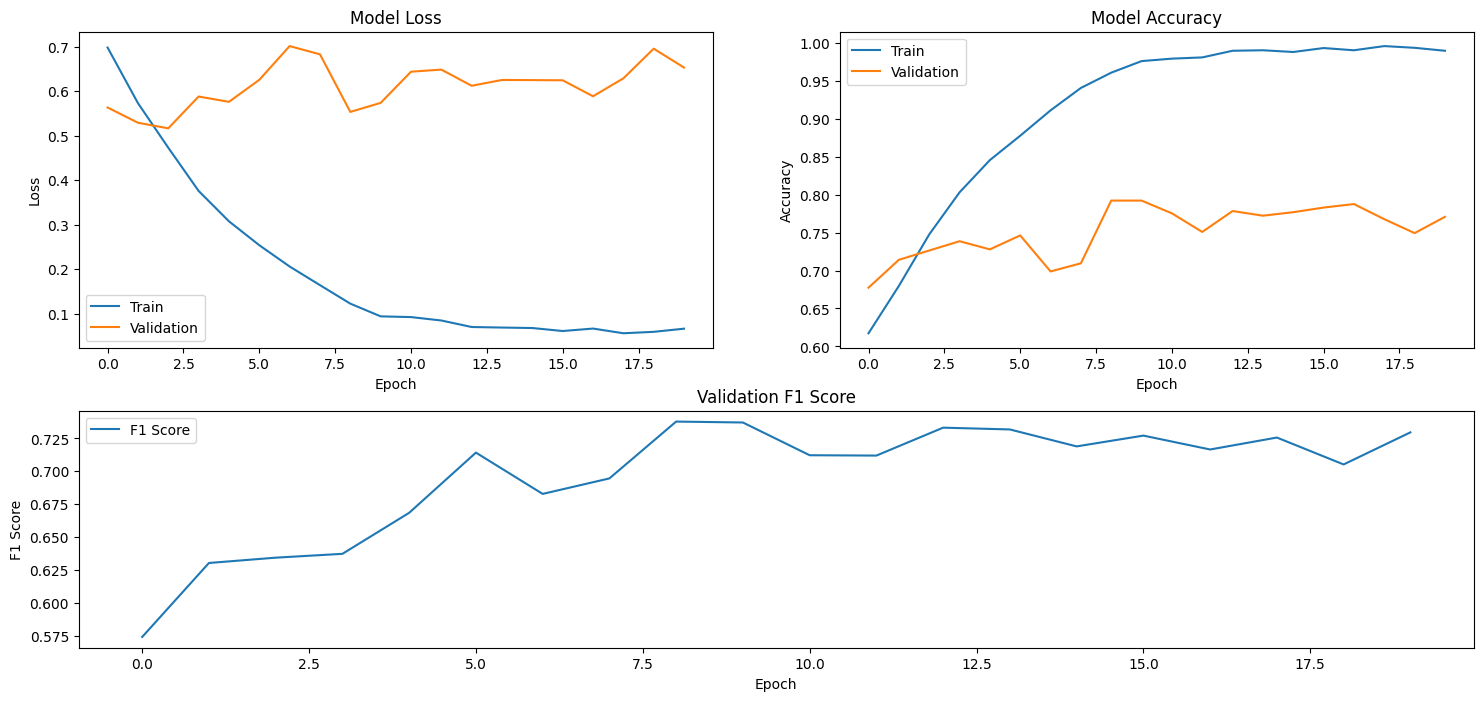

In [ ]:
plot_training_process(distillbert_history, distillbert_f1_scores)

In [ ]:
distillbert_model, distillbert_history, distillbert_f1_scores = train_bert_distilled(temperature=3.0, alpha=0.8)

accuracy,▁▂▃▄▅▆▆▇▇███████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
f1_score,▁
loss,█▇▆▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▄▅▂▃██▇▅▇▇▇▇█▇▅▇
val_f1_score,▁▃▄▄▅▇▆▆██▇▇██▇█▇▇▇█
val_loss,▃▁▁▄▃▅█▇▂▃▆▆▅▅▅▅▄▅█▆
accuracy,0.9893
best_epoch,2
best_val_loss,0.51674
epoch,19


82/82 [==============================] - 2s 29ms/step
Epoch 1/20
386/386 [==============================] - ETA: 0s - loss: 0.6992 - accuracy: 0.6115
Calculating validation F1 score...
Epoch: 1 - validation_data f1_score: 0.5732
386/386 [==============================] - 64s 110ms/step - loss: 0.6992 - accuracy: 0.6115 - val_loss: 0.5597 - val_accuracy: 0.6804
Epoch 2/20
386/386 [==============================] - ETA: 0s - loss: 0.5663 - accuracy: 0.6848
Calculating validation F1 score...
Epoch: 2 - validation_data f1_score: 0.6438
386/386 [==============================] - 26s 67ms/step - loss: 0.5663 - accuracy: 0.6848 - val_loss: 0.5057 - val_accuracy: 0.7294
Epoch 3/20
386/386 [==============================] - ETA: 0s - loss: 0.4578 - accuracy: 0.7549
Calculating validation F1 score...
Epoch: 3 - validation_data f1_score: 0.6458
386/386 [==============================] - 26s 66ms/step - loss: 0.4578 - accuracy: 0.7549 - val_loss: 0.5074 - val_accuracy: 0.7370
Epoch 4/20
386/386 [=

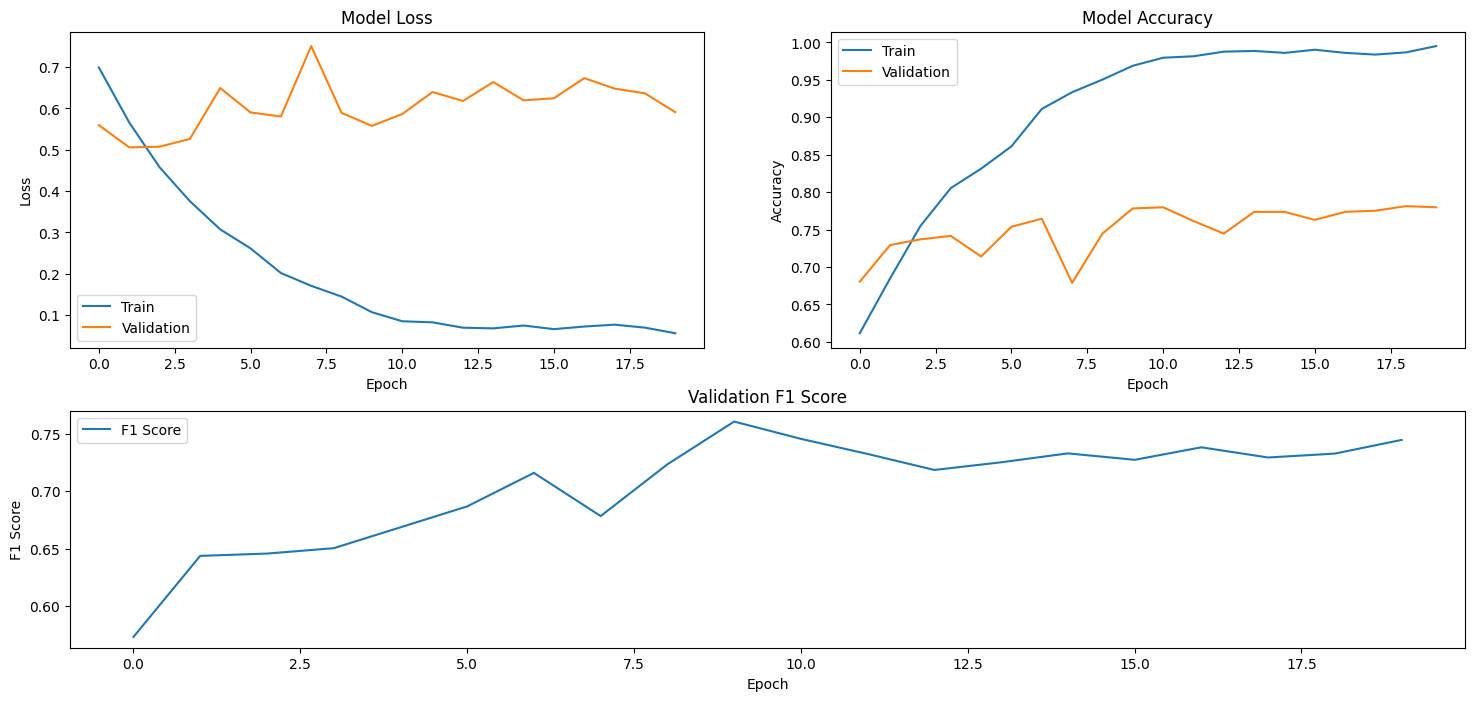

In [ ]:
plot_training_process(distillbert_history, distillbert_f1_scores)

In [19]:
distillbert_model, distillbert_history, distillbert_f1_scores = train_bert_distilled(temperature=3.0, alpha=0.2)

accuracy,▁▂▃▄▅▆▆▇▇▇██████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
f1_score,▁
loss,█▇▆▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▂▄▁▄▆▆▄▄██▇▅▇█▇▇▇▆▇▆
val_f1_score,▁▄▂▃▄▆▆▆██▇▇▇▇▇▇▇▅▇▇
val_loss,▂▁▂▄▂▂▄▅▂▄▄▅▅▅▇█▇█▅▇
accuracy,0.99611
best_epoch,1
best_val_loss,0.65807
epoch,19


82/82 [==============================] - 3s 31ms/step
Epoch 1/20
386/386 [==============================] - ETA: 0s - loss: 0.6969 - accuracy: 0.6102
Calculating validation F1 score...
Epoch: 1 - validation_data f1_score: 0.5673
386/386 [==============================] - 62s 102ms/step - loss: 0.6969 - accuracy: 0.6102 - val_loss: 0.5660 - val_accuracy: 0.6758
Epoch 2/20
385/386 [============================>.] - ETA: 0s - loss: 0.5738 - accuracy: 0.6841
Calculating validation F1 score...
Epoch: 2 - validation_data f1_score: 0.6412
386/386 [==============================] - 25s 64ms/step - loss: 0.5737 - accuracy: 0.6842 - val_loss: 0.5131 - val_accuracy: 0.7294
Epoch 3/20
386/386 [==============================] - ETA: 0s - loss: 0.4640 - accuracy: 0.7500
Calculating validation F1 score...
Epoch: 3 - validation_data f1_score: 0.6479
386/386 [==============================] - 25s 64ms/step - loss: 0.4640 - accuracy: 0.7500 - val_loss: 0.5201 - val_accuracy: 0.7431
Epoch 4/20
385/386 [=

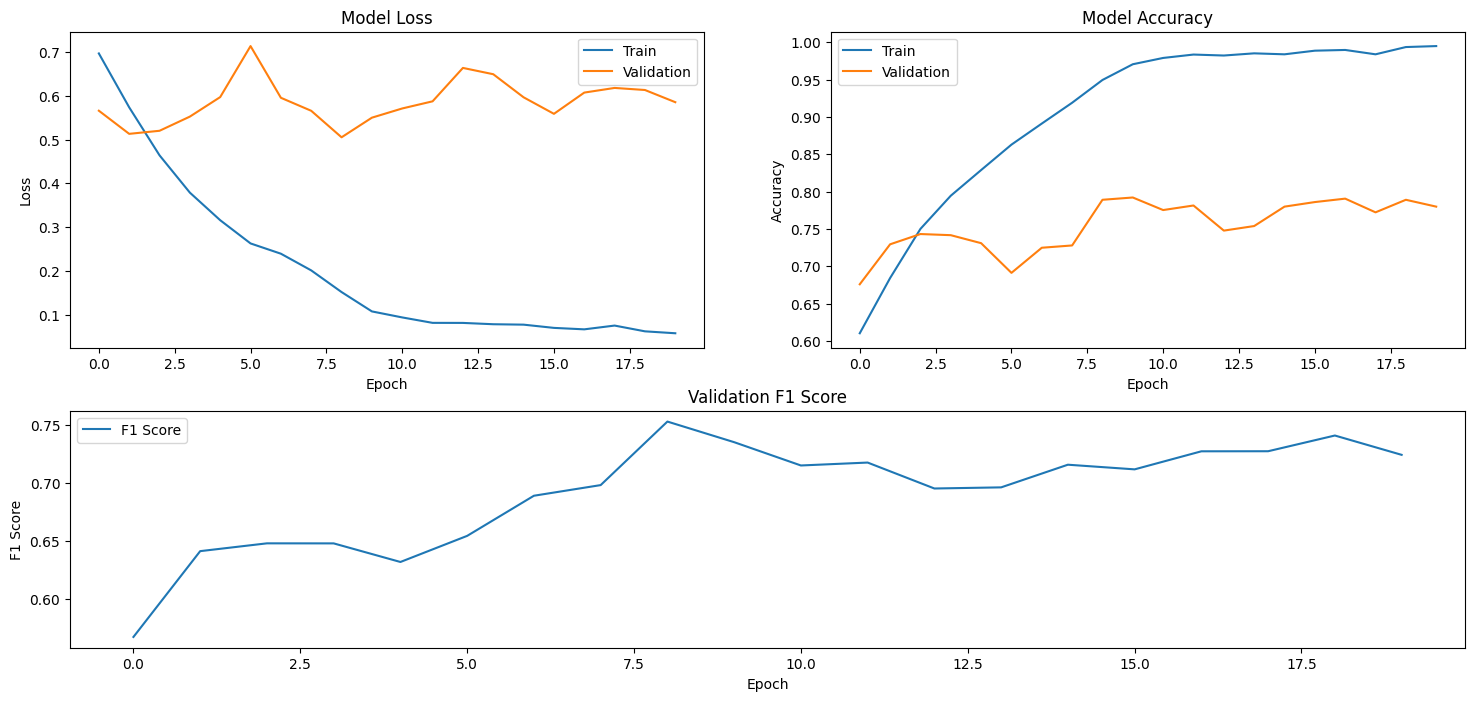

In [20]:
plot_training_process(distillbert_history, distillbert_f1_scores)

# Disconnect from Colab

Since I'm runnning using an upgraded GPU, this disconnects immediately from Colab to stop the usage timer so that I don't continue to use my GPU credits.



In [ ]:
from google.colab import runtime
runtime.unassign()